In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import svm

In [2]:
import os
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import RidgeClassifier
from catboost import CatBoostClassifier

import matplotlib.pylab as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import average_precision_score 
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import f1_score
import time

In [4]:
from sklearn import metrics
def models(clfs, feature_train, labels_train, feature_test, labels_test):
    acc = []
    auc = []
    tr_tim = []
    pr_tim = []
    run_tim = []
    precis = []
    rec = []
    ff = []
    me =[]
    for k,v in clfs.items():
        start_time = time.time()
        v.fit(feature_train, labels_train)
        tr_tim.append(time.time() - start_time)
        start_time2 = time.time()
        y_pred = v.predict(feature_test)
        pr_tim.append(time.time() - start_time2)
        run_tim.append(time.time() - start_time)
        ww1 = accuracy_score(labels_test, y_pred)
        acc.append(ww1)
        p = average_precision_score(labels_test, y_pred)
        precis.append(p)
        r = recall_score(labels_test, y_pred, average = 'micro')
        rec.append(r)
        f = f1_score(labels_test, y_pred)
        ff.append(f)
        m = mean_absolute_error(labels_test, y_pred, multioutput = 'uniform_average')
        me.append(m)
        if k == 'Decision tree' or k == 'Ridge Classifier':
            w2 = roc_auc_score(labels_test, y_pred)
            auc.append(w2)
        else:
            y_pred_prob = v.predict_proba(X_test)[:, 1]
            w2 = roc_auc_score(labels_test, y_pred_prob)
            auc.append(w2)
        print(v)
        print('Accuracy',ww1)
        print('ROC AUC',w2)
        print(metrics.confusion_matrix(labels_test, y_pred))
        print(metrics.classification_report(labels_test, y_pred))
        
        conf_matrix = confusion_matrix(y_test, y_pred)
        #print(conf_matrix)  
        #fig,ax = plt.subplots(1,5,figsize=(15,5),dpi = 120)
        #print(sns.heatmap(conf_matrix/np.sum(conf_matrix),annot=True, fmt='.2%', cmap='Blues'))
        #metrics.plot_confusion_matrix(m,X_test,y_test)
    return acc, auc, tr_tim, pr_tim, run_tim, precis,rec, m, ff

# SMS Spam Collection Dataset
### The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.

In [5]:
os.chdir("D:\ml\\a\\1")

In [6]:
df = pd.read_csv('SMSSpamCollection.txt', sep='	')
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df.shape

(5572, 2)

In [8]:
df.text[559]

'Hi Princess! Thank you for the pics. You are very pretty. How are you?'

### 5572 rows and 2 columns 

In [9]:
df.isna().sum() 

label    0
text     0
dtype: int64

### There's no null values

In [10]:
df.dtypes

label    object
text     object
dtype: object

In [11]:
df.describe()

,label,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [12]:
df.groupby('label').describe()

text                                                               
      count unique                                                top freq
label                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4







### 4825 ham and 747 spam 

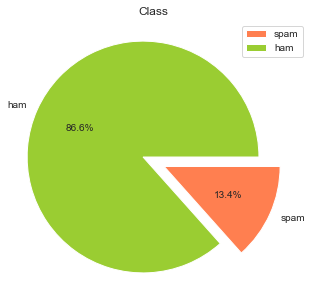

In [13]:
labels = ['spam', 'ham']
x = [747, 4825] 

fig1, ax1 = plt.subplots(figsize=(5, 5))
ax1.pie(x, labels=labels, explode = (0.3, 0),autopct='%1.1f%%', colors = ['coral','yellowgreen'], 
        radius = 1.5, counterclock = False)
ax1.axis('equal')
plt.title('Class')
ax1.legend(loc='upper left', bbox_to_anchor=(0.8, 1.0))
plt.show()

### 86.6% ham and 13.4% spam 

### Example:

In [14]:
df.iloc[2]

label                                                 spam
text     Free entry in 2 a wkly comp to win FA Cup fina...
Name: 2, dtype: object

In [15]:
df.iloc[4]

label                                                  ham
text     Nah I don't think he goes to usf, he lives aro...
Name: 4, dtype: object

### Changing the label type to int

In [16]:
df['label_num'] = df.label.map({'ham':1, 'spam':0})
df = df.drop(['label'], axis = 1)
df.head()

,text,label_num
0,"Go until jurong point, crazy.. Available only ...",1
1,Ok lar... Joking wif u oni...,1
2,Free entry in 2 a wkly comp to win FA Cup fina...,0
3,U dun say so early hor... U c already then say...,1
4,"Nah I don't think he goes to usf, he lives aro...",1


### the label is binary

In [17]:
import string
from nltk.corpus import stopwords
STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
def text_pre_pro(mess):
    mess = mess.replace('.',' ')
    nopunc = [char for char in mess if char not in string.punctuation]
    
    nopunc = ''.join(nopunc)
    
    return ' '.join([word.lower() for word in nopunc.split() if word.lower() not in STOPWORDS])

In [18]:
df['clean_text'] = df.text.apply(text_pre_pro)
df.head()

,text,label_num,clean_text
0,"Go until jurong point, crazy.. Available only ...",1,go jurong point crazy available bugis n great ...
1,Ok lar... Joking wif u oni...,1,ok lar joking wif oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,0,free entry wkly comp win fa cup final tkts 21s...
3,U dun say so early hor... U c already then say...,1,dun say early hor c already say
4,"Nah I don't think he goes to usf, he lives aro...",1,nah think goes usf lives around though


In [19]:
df = df.drop(['text'], axis = 1)

### message length

In [20]:
df['text_len'] = df.clean_text.apply(len)
df.head()

,label_num,clean_text,text_len
0,1,go jurong point crazy available bugis n great ...,82
1,1,ok lar joking wif oni,21
2,0,free entry wkly comp win fa cup final tkts 21s...,133
3,1,dun say early hor c already say,31
4,1,nah think goes usf lives around though,38


### Message length analysis

### ham messages

In [21]:
df[df.label_num==1].describe()

,label_num,text_len
count,4825.0,4825.000000
mean,1.0,44.484145
std,0.0,37.275511
min,1.0,0.000000
25%,1.0,20.000000
50%,1.0,33.000000
75%,1.0,59.000000
max,1.0,447.000000


In [22]:
df[df.text_len == 447].clean_text.iloc[0]

'love start attraction feel need every time around first thing comes thoughts would start day end every time dream love every breath name life happen around life named would cry give happiness take sorrows ready fight anyone love craziest things love proove anyone girl beautiful lady whole planet always singing praises love start making chicken curry end makiing sambar life beautiful get every morning thank god day would like say lot tell later'

### spam messages

In [23]:
df[df.label_num==0].describe()

,label_num,text_len
count,747.0,747.000000
mean,0.0,105.674699
std,0.0,25.173179
min,0.0,12.000000
25%,0.0,94.500000
50%,0.0,110.000000
75%,0.0,124.000000
max,0.0,158.000000


Text(0, 0.5, 'Quantity')

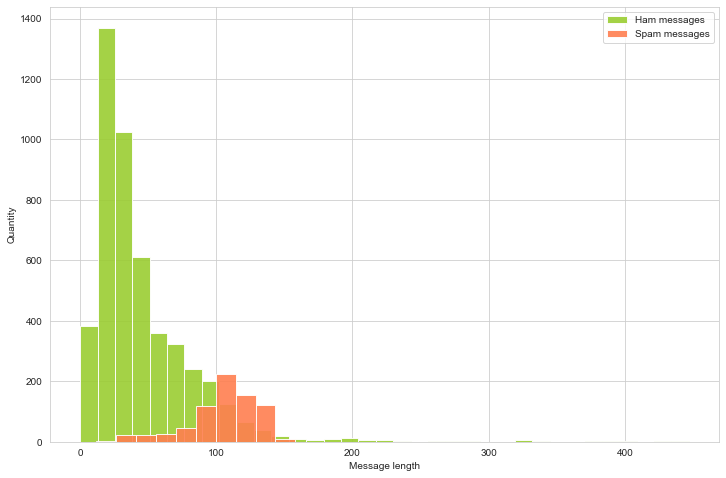

In [24]:
plt.figure(figsize=(12, 8))

df[df.label_num==1].text_len.plot(bins=35, kind='hist', color='yellowgreen', 
                                       label='Ham messages', alpha=0.9)
df[df.label_num==0].text_len.plot(kind='hist', color='coral', 
                                       label='Spam messages', alpha=0.9)
plt.legend()
plt.xlabel('Message length')

plt.ylabel('Quantity')

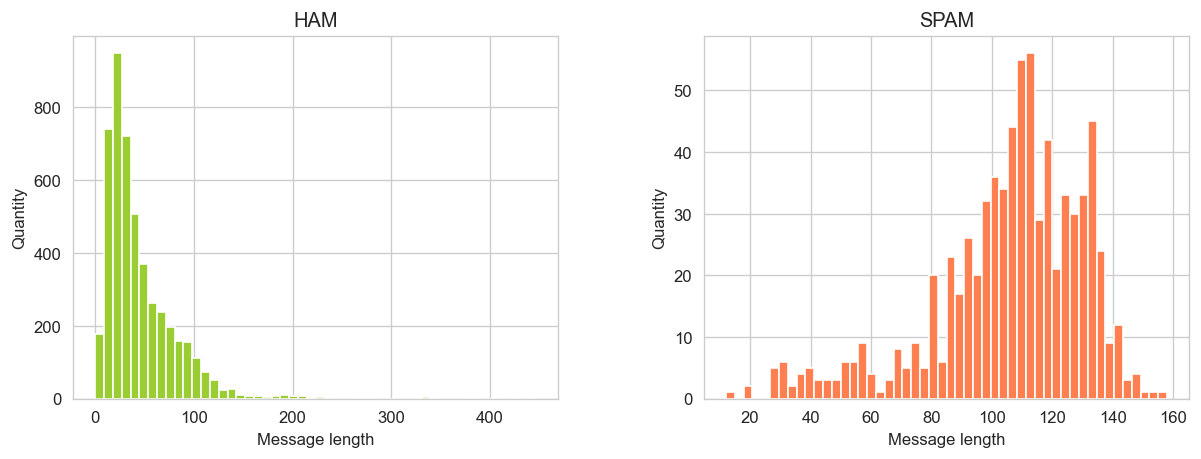

In [25]:
fig,ax = plt.subplots(1,2,figsize=(12,4),dpi = 120)

df[df['label_num']==1].hist(column='text_len', bins=50,ax=ax[0],color = 'yellowgreen')
ax[0].set(xlabel = 'Message length',ylabel = 'Quantity',title = 'HAM')
df[df['label_num']==0].hist(column='text_len', bins=50,ax=ax[1],color = 'coral')
ax[1].set(xlabel = 'Message length',ylabel = 'Quantity',title = 'SPAM');

In [26]:
df.dtypes

label_num      int64
clean_text    object
text_len       int64
dtype: object

### Train test split

In [82]:
X = df['clean_text']
y = df['label_num']

In [123]:
X_train1, X_test1, y_train, y_test = train_test_split(X, y,  test_size = 0.3)
print(X_train1.shape)
print(X_test1.shape)
print(y_train.shape)
print(y_test.shape)

(3900,)
(1672,)
(3900,)
(1672,)


In [124]:
cv = CountVectorizer()
cv.fit(X_train1)

len(cv.vocabulary_)

7290

In [125]:
X_train = cv.transform(X_train1)
X_train

<3900x7290 sparse matrix of type '<class 'numpy.int64'>'
	with 32919 stored elements in Compressed Sparse Row format>

In [126]:
print(X_train1[X_train1.index[3]])

ok shell ok guess


In [127]:
X_train[3].nonzero()

(array([0, 0, 0]), array([3098, 4673, 5748]))

In [128]:
X_test = cv.transform(X_test1)

In [129]:
print ('Vocabulary:') 
print (cv.vocabulary_) 

Vocabulary:
{'tired': 6505, 'special': 6024, 'office': 4657, 'na': 4446, 'already': 917, 'one': 4691, 'guy': 3107, 'loving': 4034, 'ok': 4673, 'shell': 5748, 'guess': 3098, 'think': 6444, 'waiting': 6916, 'bus': 1517, 'inform': 3479, 'get': 2958, 'ever': 2532, 'ltgt': 4052, 'fast': 2637, 'approaching': 1025, 'wish': 7085, 'happy': 3158, 'new': 4514, 'year': 7221, 'sankranti': 5579, 'republic': 5413, 'day': 2098, 'valentines': 6818, 'shivratri': 5772, 'ugadi': 6701, 'fools': 2780, 'may': 4185, 'independence': 3467, 'friendshipmotherfatherteacherschildrens': 2849, 'amp': 941, 'birthday': 1332, 'ganesh': 2914, 'festival': 2670, 'dasara': 2087, 'diwali': 2269, 'christmas': 1752, 'good': 3020, 'mornings': 4369, 'afternoons': 853, 'evenings': 2528, 'nights': 4534, 'rememberi': 5384, 'first': 2725, 'wishing': 7089, 'raj': 5260, 'ryder': 5549, 'unsold': 6755, 'gibbs': 2970, 'free': 2824, 'camera': 1577, 'phones': 4924, 'linerental': 3929, '49month': 517, '750': 627, 'cross': 2003, 'ntwk': 4612

## Models

In [130]:
mnb = MultinomialNB()
lrc = LogisticRegression()
svc = SVC(probability=True, random_state = 42)
dtc = DecisionTreeClassifier(random_state = 42)
rfc = RandomForestClassifier(random_state = 42)
knn = KNeighborsClassifier()
mlp = MLPClassifier(random_state = 42)
grd = GradientBoostingClassifier(random_state = 42)
rdg = RidgeClassifier(random_state = 42)
cbc = CatBoostClassifier(random_state = 42)

In [131]:
clfs = {'Naive Bayes': mnb, 'Logistic regression': lrc,'SVM': svc, 'Decision tree': dtc, 
        'Random forest': rfc, 'k Nearest Neighbor': knn, 'Multilayer Perceptron Classifier':mlp, 
        'Gradient boosting': grd, 'Ridge Classifier': rdg, 'CatBoostClassifier': cbc}

In [132]:
r1, r2, tr_tim, pr_tim, run_tim, precis,rec,mean_er, ff = models(clfs, X_train, y_train, X_test, y_test)

MultinomialNB()
Accuracy 0.979066985645933
ROC AUC 0.9700475539052831
[[ 189   21]
 [  14 1448]]
              precision    recall  f1-score   support

           0       0.93      0.90      0.92       210
           1       0.99      0.99      0.99      1462

    accuracy                           0.98      1672
   macro avg       0.96      0.95      0.95      1672
weighted avg       0.98      0.98      0.98      1672

LogisticRegression()
Accuracy 0.9772727272727273
ROC AUC 0.9843560680085988
[[ 174   36]
 [   2 1460]]
              precision    recall  f1-score   support

           0       0.99      0.83      0.90       210
           1       0.98      1.00      0.99      1462

    accuracy                           0.98      1672
   macro avg       0.98      0.91      0.94      1672
weighted avg       0.98      0.98      0.98      1672

SVC(probability=True, random_state=42)
Accuracy 0.9700956937799043
ROC AUC 0.9787082274770372
[[ 160   50]
 [   0 1462]]
              precision  

84:	learn: 0.1916080	total: 5.84s	remaining: 1m 2s
85:	learn: 0.1903175	total: 5.89s	remaining: 1m 2s
86:	learn: 0.1891372	total: 5.96s	remaining: 1m 2s
87:	learn: 0.1879538	total: 6.02s	remaining: 1m 2s
88:	learn: 0.1870133	total: 6.08s	remaining: 1m 2s
89:	learn: 0.1856727	total: 6.14s	remaining: 1m 2s
90:	learn: 0.1844594	total: 6.2s	remaining: 1m 1s
91:	learn: 0.1832506	total: 6.26s	remaining: 1m 1s
92:	learn: 0.1821187	total: 6.34s	remaining: 1m 1s
93:	learn: 0.1809217	total: 6.41s	remaining: 1m 1s
94:	learn: 0.1799132	total: 6.49s	remaining: 1m 1s
95:	learn: 0.1790239	total: 6.56s	remaining: 1m 1s
96:	learn: 0.1779415	total: 6.63s	remaining: 1m 1s
97:	learn: 0.1767876	total: 6.7s	remaining: 1m 1s
98:	learn: 0.1757224	total: 6.76s	remaining: 1m 1s
99:	learn: 0.1746664	total: 6.82s	remaining: 1m 1s
100:	learn: 0.1736556	total: 6.88s	remaining: 1m 1s
101:	learn: 0.1726446	total: 6.94s	remaining: 1m 1s
102:	learn: 0.1716124	total: 7.02s	remaining: 1m 1s
103:	learn: 0.1707759	total: 7

246:	learn: 0.1136456	total: 17.9s	remaining: 54.5s
247:	learn: 0.1133742	total: 17.9s	remaining: 54.4s
248:	learn: 0.1132365	total: 18s	remaining: 54.3s
249:	learn: 0.1130940	total: 18.1s	remaining: 54.2s
250:	learn: 0.1129794	total: 18.1s	remaining: 54.1s
251:	learn: 0.1128405	total: 18.2s	remaining: 53.9s
252:	learn: 0.1125439	total: 18.2s	remaining: 53.9s
253:	learn: 0.1124269	total: 18.3s	remaining: 53.7s
254:	learn: 0.1122677	total: 18.4s	remaining: 53.6s
255:	learn: 0.1120240	total: 18.4s	remaining: 53.6s
256:	learn: 0.1118157	total: 18.5s	remaining: 53.4s
257:	learn: 0.1116712	total: 18.5s	remaining: 53.3s
258:	learn: 0.1115531	total: 18.6s	remaining: 53.2s
259:	learn: 0.1114222	total: 18.7s	remaining: 53.1s
260:	learn: 0.1111887	total: 18.7s	remaining: 53s
261:	learn: 0.1109397	total: 18.8s	remaining: 53s
262:	learn: 0.1108505	total: 18.9s	remaining: 52.9s
263:	learn: 0.1107277	total: 18.9s	remaining: 52.8s
264:	learn: 0.1103870	total: 19s	remaining: 52.7s
265:	learn: 0.110228

407:	learn: 0.0913202	total: 28.4s	remaining: 41.2s
408:	learn: 0.0912674	total: 28.5s	remaining: 41.1s
409:	learn: 0.0911938	total: 28.5s	remaining: 41.1s
410:	learn: 0.0910061	total: 28.6s	remaining: 41s
411:	learn: 0.0909435	total: 28.7s	remaining: 40.9s
412:	learn: 0.0907600	total: 28.7s	remaining: 40.8s
413:	learn: 0.0907062	total: 28.8s	remaining: 40.8s
414:	learn: 0.0905588	total: 28.9s	remaining: 40.7s
415:	learn: 0.0905010	total: 28.9s	remaining: 40.6s
416:	learn: 0.0902817	total: 29s	remaining: 40.5s
417:	learn: 0.0902225	total: 29s	remaining: 40.4s
418:	learn: 0.0900129	total: 29.1s	remaining: 40.3s
419:	learn: 0.0899592	total: 29.2s	remaining: 40.3s
420:	learn: 0.0899078	total: 29.2s	remaining: 40.2s
421:	learn: 0.0898507	total: 29.3s	remaining: 40.1s
422:	learn: 0.0897883	total: 29.3s	remaining: 40s
423:	learn: 0.0897283	total: 29.4s	remaining: 39.9s
424:	learn: 0.0896795	total: 29.5s	remaining: 39.9s
425:	learn: 0.0896202	total: 29.5s	remaining: 39.8s
426:	learn: 0.089564

568:	learn: 0.0769604	total: 39.2s	remaining: 29.7s
569:	learn: 0.0769198	total: 39.3s	remaining: 29.6s
570:	learn: 0.0768798	total: 39.4s	remaining: 29.6s
571:	learn: 0.0767032	total: 39.4s	remaining: 29.5s
572:	learn: 0.0766642	total: 39.5s	remaining: 29.5s
573:	learn: 0.0766256	total: 39.6s	remaining: 29.4s
574:	learn: 0.0765610	total: 39.7s	remaining: 29.4s
575:	learn: 0.0765228	total: 39.8s	remaining: 29.3s
576:	learn: 0.0764842	total: 39.8s	remaining: 29.2s
577:	learn: 0.0764462	total: 39.9s	remaining: 29.1s
578:	learn: 0.0764068	total: 40s	remaining: 29.1s
579:	learn: 0.0763684	total: 40.1s	remaining: 29s
580:	learn: 0.0761873	total: 40.2s	remaining: 29s
581:	learn: 0.0760256	total: 40.2s	remaining: 28.9s
582:	learn: 0.0758283	total: 40.3s	remaining: 28.8s
583:	learn: 0.0757670	total: 40.4s	remaining: 28.8s
584:	learn: 0.0757278	total: 40.5s	remaining: 28.7s
585:	learn: 0.0756679	total: 40.6s	remaining: 28.6s
586:	learn: 0.0754770	total: 40.6s	remaining: 28.6s
587:	learn: 0.0754

727:	learn: 0.0648739	total: 50.6s	remaining: 18.9s
728:	learn: 0.0648450	total: 50.7s	remaining: 18.9s
729:	learn: 0.0647040	total: 50.8s	remaining: 18.8s
730:	learn: 0.0645676	total: 50.9s	remaining: 18.7s
731:	learn: 0.0645389	total: 50.9s	remaining: 18.7s
732:	learn: 0.0645108	total: 51s	remaining: 18.6s
733:	learn: 0.0643844	total: 51.1s	remaining: 18.5s
734:	learn: 0.0642059	total: 51.1s	remaining: 18.4s
735:	learn: 0.0640505	total: 51.2s	remaining: 18.4s
736:	learn: 0.0640066	total: 51.3s	remaining: 18.3s
737:	learn: 0.0639784	total: 51.3s	remaining: 18.2s
738:	learn: 0.0639048	total: 51.4s	remaining: 18.2s
739:	learn: 0.0637583	total: 51.5s	remaining: 18.1s
740:	learn: 0.0637297	total: 51.5s	remaining: 18s
741:	learn: 0.0637013	total: 51.6s	remaining: 17.9s
742:	learn: 0.0635310	total: 51.6s	remaining: 17.9s
743:	learn: 0.0635026	total: 51.7s	remaining: 17.8s
744:	learn: 0.0634744	total: 51.8s	remaining: 17.7s
745:	learn: 0.0634300	total: 51.8s	remaining: 17.6s
746:	learn: 0.06

KeyboardInterrupt: 

In [ ]:
res_mod1 = pd.DataFrame(run_tim, index=list(clfs.keys()), columns=['Run time'])
res_mod1['Traing time'] = tr_tim
res_mod1['Test time'] = pr_tim
res_mod1['Accuracy'] = r1
res_mod1['ROC AUC'] = r2
res_mod1['Precision'] = precis
res_mod1['Recall'] = rec
res_mod1['F1'] = ff

In [45]:
mean_er

0.029904306220095694

In [46]:
res_mod1

,Run time,Traing time,Test time,Accuracy,ROC AUC,Precision,Recall,F1
Naive Bayes,0.293365,0.033312,0.260052,0.984450,0.985477,0.988122,0.984450,0.991028
Logistic regression,17.555859,17.554868,0.000992,0.981459,0.985805,0.981297,0.981459,0.989365
SVM,6.555115,6.216391,0.338724,0.979067,0.977350,0.978070,0.979067,0.988018
Decision tree,0.305449,0.300405,0.005044,0.951555,0.897327,0.969271,0.951555,0.971982
Random forest,2.023336,1.884270,0.139067,0.976077,0.985333,0.973082,0.976077,0.986357
k Nearest Neighbor,0.515277,0.001989,0.513288,0.905502,0.818584,0.901496,0.905502,0.948197
Multilayer Perceptron Classifier,133.024848,133.006966,0.017882,0.981459,0.980902,0.979012,0.981459,0.989394
Gradient boosting,2.042193,2.018699,0.023494,0.955742,0.963926,0.958866,0.955742,0.974813
Ridge Classifier,0.200248,0.199251,0.000996,0.983254,0.938053,0.981004,0.983254,0.990411
CatBoostClassifier,80.694053,80.482375,0.211678,0.970096,0.983216,0.969355,0.970096,0.982947


In [47]:
from sklearn.metrics import roc_curve
# функция выводит основные метрики для оценки качества модели и возвращает вектор предсказанных значений
def mod2(m,X_train, y_train,X_test,y_test):
    m.fit(X_train, y_train)
    y_pred_class = m.predict(X_test)
    y_pred_prob = m.predict_proba(X_test)[:, 1]
    # calculate accuracy
    print('Accuracy',metrics.accuracy_score(y_test, y_pred_class))
    # calculate AUC
    print('ROC AUC',metrics.roc_auc_score(y_test, y_pred_prob))
    print('F1-score',f1_score(y_test, y_pred_class))
    print('')

    print(classification_report(y_test,y_pred_class))

    conf_matrix = metrics.confusion_matrix(y_test, y_pred_class)
    print(conf_matrix)  
    sns.heatmap(conf_matrix/np.sum(conf_matrix),annot=True, fmt='.2%', cmap='Blues')
    #metrics.plot_confusion_matrix(m,X_test,y_test)

    probs = m.predict_proba(X_test)
    probs = probs[:, 1]
    fpr , tpr , _ = roc_curve(y_test, probs)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
          lw=lw, label='ROC curve (area = %0.2f)' % metrics.auc(fpr,tpr))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.1, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC AUC {m}')
    plt.legend(loc="lower right")
    plt.grid()
    return y_pred_class

In [137]:
X_train1, X_test1, y_train, y_test = train_test_split(X, y,  test_size = 0.3)
print(X_train1.shape)
print(X_test1.shape)
print(y_train.shape)
print(y_test.shape)
cv = CountVectorizer()
cv.fit(X_train1)

len(cv.vocabulary_)
X_train = cv.transform(X_train1)
X_train
X_test = cv.transform(X_test1)

(3900,)
(1672,)
(3900,)
(1672,)


Accuracy 0.9784688995215312
ROC AUC 0.9832310838445807
F1-score 0.9878706199460916

              precision    recall  f1-score   support

           0       0.99      0.83      0.90       205
           1       0.98      1.00      0.99      1467

    accuracy                           0.98      1672
   macro avg       0.99      0.91      0.95      1672
weighted avg       0.98      0.98      0.98      1672

[[ 170   35]
 [   1 1466]]


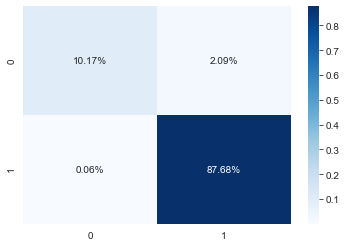

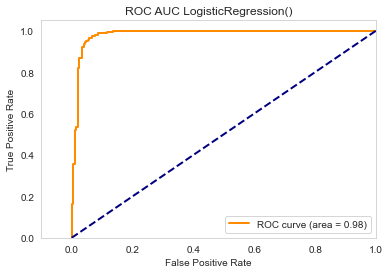

In [138]:
for_gr_l = mod2(lrc,X_train, y_train,X_test,y_test)

In [43]:
X1_train, X1_tes1, y1_train, y1_test = X_train, X_test, y_train, y_test

# Email Spambase Data Set
### 48 continuous real [0,100] attributes of type word_freq_WORD
= percentage of words in the e-mail that match WORD, i.e. 100 * (number of times the WORD appears in the e-mail) / total number of words in e-mail. A "word" in this case is any string of alphanumeric characters bounded by non-alphanumeric characters or end-of-string.

### 6 continuous real [0,100] attributes of type char_freq_CHAR
= percentage of characters in the e-mail that match CHAR, i.e. 100 * (number of CHAR occurences) / total characters in e-mail
#### %3B - ';'
#### %5B - '['
#### %21 - '!'
#### %24 - '$'
#### %23 - '#'

### 1 continuous real [1,...] attribute of type capital_run_length_average
= average length of uninterrupted sequences of capital letters

### 1 continuous integer [1,...] attribute of type capital_run_length_longest
= length of longest uninterrupted sequence of capital letters

### 1 continuous integer [1,...] attribute of type capital_run_length_total
= sum of length of uninterrupted sequences of capital letters
= total number of capital letters in the e-mail

### 1 nominal {0,1} class attribute of type spam
= denotes whether the e-mail was considered spam (1) or not (0), i.e. unsolicited commercial e-mail.

In [647]:
import os
os.chdir("D:\ml\\a\\2")

In [648]:
df = pd.read_csv('spambase_csv.csv')
df.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_%3B,char_freq_%28,char_freq_%5B,char_freq_%21,char_freq_%24,char_freq_%23,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [649]:
df.shape

(4601, 58)

In [650]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 58 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   word_freq_make              4601 non-null   float64
 1   word_freq_address           4601 non-null   float64
 2   word_freq_all               4601 non-null   float64
 3   word_freq_3d                4601 non-null   float64
 4   word_freq_our               4601 non-null   float64
 5   word_freq_over              4601 non-null   float64
 6   word_freq_remove            4601 non-null   float64
 7   word_freq_internet          4601 non-null   float64
 8   word_freq_order             4601 non-null   float64
 9   word_freq_mail              4601 non-null   float64
 10  word_freq_receive           4601 non-null   float64
 11  word_freq_will              4601 non-null   float64
 12  word_freq_people            4601 non-null   float64
 13  word_freq_report            4601 

In [651]:
df.describe()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_%3B,char_freq_%28,char_freq_%5B,char_freq_%21,char_freq_%24,char_freq_%23,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
count,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,...,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000
mean,0.104553,0.213015,0.280656,0.065425,0.312223,0.095901,0.114208,0.105295,0.090067,0.239413,...,0.038575,0.139030,0.016976,0.269071,0.075811,0.044238,5.191515,52.172789,283.289285,0.394045
std,0.305358,1.290575,0.504143,1.395151,0.672513,0.273824,0.391441,0.401071,0.278616,0.644755,...,0.243471,0.270355,0.109394,0.815672,0.245882,0.429342,31.729449,194.891310,606.347851,0.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.588000,6.000000,35.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.065000,0.000000,0.000000,0.000000,0.000000,2.276000,15.000000,95.000000,0.000000
75%,0.000000,0.000000,0.420000,0.000000,0.380000,0.000000,0.000000,0.000000,0.000000,0.160000,...,0.000000,0.188000,0.000000,0.315000,0.052000,0.000000,3.706000,43.000000,266.000000,1.000000
max,4.540000,14.280000,5.100000,42.810000,10.000000,5.880000,7.270000,11.110000,5.260000,18.180000,...,4.385000,9.752000,4.081000,32.478000,6.003000,19.829000,1102.500000,9989.000000,15841.000000,1.000000


In [652]:
df.isna().sum() 

word_freq_make                0
word_freq_address             0
word_freq_all                 0
word_freq_3d                  0
word_freq_our                 0
word_freq_over                0
word_freq_remove              0
word_freq_internet            0
word_freq_order               0
word_freq_mail                0
word_freq_receive             0
word_freq_will                0
word_freq_people              0
word_freq_report              0
word_freq_addresses           0
word_freq_free                0
word_freq_business            0
word_freq_email               0
word_freq_you                 0
word_freq_credit              0
word_freq_your                0
word_freq_font                0
word_freq_000                 0
word_freq_money               0
word_freq_hp                  0
word_freq_hpl                 0
word_freq_george              0
word_freq_650                 0
word_freq_lab                 0
word_freq_labs                0
word_freq_telnet              0
word_fre

### There's no null values

In [653]:
df.groupby('class').describe()

word_freq_make                                                 \
               count      mean       std  min  25%  50%   75%   max   
class                                                                 
0             2788.0  0.073479  0.297838  0.0  0.0  0.0  0.00  4.34   
1             1813.0  0.152339  0.310645  0.0  0.0  0.0  0.17  4.54   

      word_freq_address            ... capital_run_length_longest          \
                  count      mean  ...                        75%     max   
class                              ...                                      
0                2788.0  0.244466  ...                       18.0  1488.0   
1                1813.0  0.164650  ...                       84.0  9989.0   

      capital_run_length_total                                             \
                         count        mean         std  min    25%    50%   
class                                                                       
0                       2788.0  161.470947  355.738403  1.0  18.75   54.0   
1                       1813.0  470.619415  825.081179  2.0  93.00  194.0   

                       
         75%      max  
class                  
0      141.0   5902.0  
1      530.0  15841.0  

[2 rows x 456 columns]

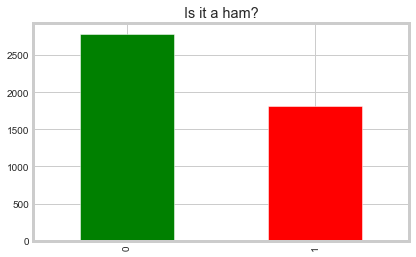

In [654]:
count_class=pd.value_counts(df["class"], sort= 1)
count_class.plot(kind= 'bar', color= ["green", "red"])
plt.title('Is it a ham?')
plt.show()

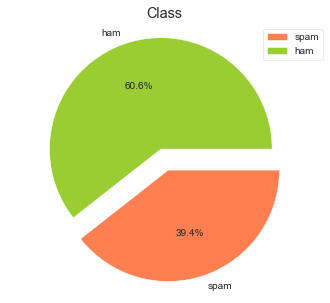

In [655]:
labels = ['spam', 'ham']
x = [1813, 2788] 

fig1, ax1 = plt.subplots(figsize=(5, 5))
ax1.pie(x, labels=labels, explode = (0.3, 0),autopct='%1.1f%%', colors = ['coral','yellowgreen'], 
        radius = 1.5, counterclock = False)
plt.title('Class')
ax1.axis('equal')
ax1.legend(loc='upper left', bbox_to_anchor=(0.8, 1.0))
plt.show()

<AxesSubplot:>

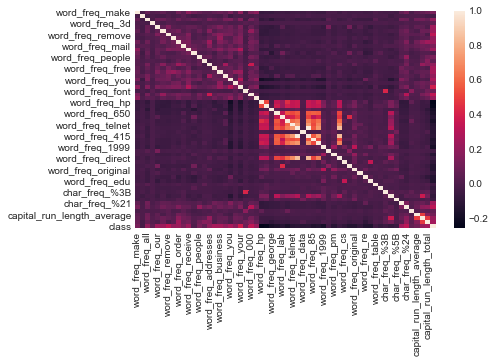

In [656]:
fig, ax = plt.subplots()
sns.heatmap(df.corr(), ax=ax)

In [657]:
CorrKoef = df.corr()
FieldDrop = [i for i in CorrKoef if CorrKoef[i].isnull().drop_duplicates().values[0]]

In [658]:
CorField = []
for i in CorrKoef:
    for j in CorrKoef.index[(CorrKoef[i] > 0.8) | (CorrKoef[i] < -0.7)]:
        if i != j and (j not in CorField) and (i not in CorField):
            CorField.append(j)
            print( "%s --> %s: Corr = %f" % (i,j, CorrKoef[i][CorrKoef.index==j].values[0]))

word_freq_857 --> word_freq_415: Corr = 0.996066
word_freq_857 --> word_freq_direct: Corr = 0.848021


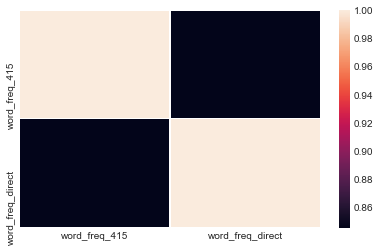

In [659]:
cols = CorField
hm = sns.heatmap(df[cols].corr(), cbar=True,  linewidths=.1)

In [660]:
X = df.drop(['class'], axis=1)
y = df['class']

In [661]:
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size = 0.3)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3220, 57)
(1381, 57)
(3220,)
(1381,)


In [662]:
r1, r2, tr_tim, pr_tim, run_tim, precis,rec,mean_er, ff = models(clfs, X_train, y_train, X_test, y_test)

MultinomialNB()
Accuracy 0.8008689355539464
ROC AUC 0.8495515220468587
[[715 128]
 [147 391]]
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       843
           1       0.75      0.73      0.74       538

    accuracy                           0.80      1381
   macro avg       0.79      0.79      0.79      1381
weighted avg       0.80      0.80      0.80      1381



C:\Users\Admin\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()
Accuracy 0.9304851556842868
ROC AUC 0.9684092041610993
[[797  46]
 [ 50 488]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       843
           1       0.91      0.91      0.91       538

    accuracy                           0.93      1381
   macro avg       0.93      0.93      0.93      1381
weighted avg       0.93      0.93      0.93      1381

SVC(probability=True, random_state=42)
Accuracy 0.7139753801593048
ROC AUC 0.8059605233565731
[[740 103]
 [292 246]]
              precision    recall  f1-score   support

           0       0.72      0.88      0.79       843
           1       0.70      0.46      0.55       538

    accuracy                           0.71      1381
   macro avg       0.71      0.67      0.67      1381
weighted avg       0.71      0.71      0.70      1381

DecisionTreeClassifier(random_state=42)
Accuracy 0.9123823316437364
ROC AUC 0.9100750991105407
[[776  67]
 [ 54 484]]
            

95:	learn: 0.1915438	total: 2.68s	remaining: 25.3s
96:	learn: 0.1906150	total: 2.71s	remaining: 25.2s
97:	learn: 0.1897409	total: 2.74s	remaining: 25.2s
98:	learn: 0.1893231	total: 2.77s	remaining: 25.2s
99:	learn: 0.1884194	total: 2.79s	remaining: 25.2s
100:	learn: 0.1873975	total: 2.82s	remaining: 25.1s
101:	learn: 0.1864994	total: 2.85s	remaining: 25.1s
102:	learn: 0.1852955	total: 2.89s	remaining: 25.1s
103:	learn: 0.1846843	total: 2.91s	remaining: 25.1s
104:	learn: 0.1839489	total: 2.94s	remaining: 25.1s
105:	learn: 0.1829876	total: 2.96s	remaining: 25s
106:	learn: 0.1822635	total: 3s	remaining: 25s
107:	learn: 0.1813618	total: 3.04s	remaining: 25.1s
108:	learn: 0.1805334	total: 3.07s	remaining: 25.1s
109:	learn: 0.1799085	total: 3.09s	remaining: 25s
110:	learn: 0.1794175	total: 3.12s	remaining: 25s
111:	learn: 0.1788050	total: 3.14s	remaining: 24.9s
112:	learn: 0.1781576	total: 3.16s	remaining: 24.8s
113:	learn: 0.1773495	total: 3.19s	remaining: 24.8s
114:	learn: 0.1764811	total:

261:	learn: 0.1300154	total: 7.26s	remaining: 20.4s
262:	learn: 0.1299587	total: 7.29s	remaining: 20.4s
263:	learn: 0.1298719	total: 7.31s	remaining: 20.4s
264:	learn: 0.1297283	total: 7.34s	remaining: 20.4s
265:	learn: 0.1297027	total: 7.37s	remaining: 20.3s
266:	learn: 0.1295494	total: 7.39s	remaining: 20.3s
267:	learn: 0.1294193	total: 7.42s	remaining: 20.3s
268:	learn: 0.1290892	total: 7.45s	remaining: 20.2s
269:	learn: 0.1288866	total: 7.47s	remaining: 20.2s
270:	learn: 0.1286678	total: 7.5s	remaining: 20.2s
271:	learn: 0.1285766	total: 7.53s	remaining: 20.2s
272:	learn: 0.1284031	total: 7.55s	remaining: 20.1s
273:	learn: 0.1283017	total: 7.59s	remaining: 20.1s
274:	learn: 0.1281549	total: 7.62s	remaining: 20.1s
275:	learn: 0.1279565	total: 7.65s	remaining: 20.1s
276:	learn: 0.1278165	total: 7.68s	remaining: 20s
277:	learn: 0.1276988	total: 7.71s	remaining: 20s
278:	learn: 0.1274601	total: 7.73s	remaining: 20s
279:	learn: 0.1274305	total: 7.75s	remaining: 19.9s
280:	learn: 0.12724

420:	learn: 0.1124686	total: 11.6s	remaining: 16s
421:	learn: 0.1124340	total: 11.7s	remaining: 16s
422:	learn: 0.1123846	total: 11.7s	remaining: 15.9s
423:	learn: 0.1123136	total: 11.7s	remaining: 15.9s
424:	learn: 0.1121882	total: 11.8s	remaining: 15.9s
425:	learn: 0.1121586	total: 11.8s	remaining: 15.9s
426:	learn: 0.1120866	total: 11.8s	remaining: 15.9s
427:	learn: 0.1120755	total: 11.9s	remaining: 15.8s
428:	learn: 0.1120494	total: 11.9s	remaining: 15.8s
429:	learn: 0.1118312	total: 11.9s	remaining: 15.8s
430:	learn: 0.1117555	total: 12s	remaining: 15.8s
431:	learn: 0.1116099	total: 12s	remaining: 15.8s
432:	learn: 0.1114329	total: 12s	remaining: 15.7s
433:	learn: 0.1113524	total: 12s	remaining: 15.7s
434:	learn: 0.1112550	total: 12.1s	remaining: 15.7s
435:	learn: 0.1111921	total: 12.1s	remaining: 15.7s
436:	learn: 0.1111776	total: 12.1s	remaining: 15.6s
437:	learn: 0.1111028	total: 12.2s	remaining: 15.6s
438:	learn: 0.1110742	total: 12.2s	remaining: 15.6s
439:	learn: 0.1109373	to

582:	learn: 0.0997196	total: 16.9s	remaining: 12.1s
583:	learn: 0.0997103	total: 16.9s	remaining: 12.1s
584:	learn: 0.0994258	total: 17s	remaining: 12s
585:	learn: 0.0992933	total: 17s	remaining: 12s
586:	learn: 0.0991492	total: 17s	remaining: 12s
587:	learn: 0.0991396	total: 17.1s	remaining: 12s
588:	learn: 0.0990644	total: 17.1s	remaining: 11.9s
589:	learn: 0.0989267	total: 17.1s	remaining: 11.9s
590:	learn: 0.0989182	total: 17.2s	remaining: 11.9s
591:	learn: 0.0988247	total: 17.2s	remaining: 11.9s
592:	learn: 0.0986758	total: 17.2s	remaining: 11.8s
593:	learn: 0.0985738	total: 17.3s	remaining: 11.8s
594:	learn: 0.0984206	total: 17.3s	remaining: 11.8s
595:	learn: 0.0982174	total: 17.3s	remaining: 11.7s
596:	learn: 0.0982100	total: 17.4s	remaining: 11.7s
597:	learn: 0.0980845	total: 17.4s	remaining: 11.7s
598:	learn: 0.0980567	total: 17.4s	remaining: 11.7s
599:	learn: 0.0979043	total: 17.5s	remaining: 11.6s
600:	learn: 0.0976944	total: 17.5s	remaining: 11.6s
601:	learn: 0.0976863	tota

742:	learn: 0.0864363	total: 21.8s	remaining: 7.55s
743:	learn: 0.0863740	total: 21.9s	remaining: 7.52s
744:	learn: 0.0863062	total: 21.9s	remaining: 7.49s
745:	learn: 0.0862859	total: 21.9s	remaining: 7.47s
746:	learn: 0.0862508	total: 22s	remaining: 7.44s
747:	learn: 0.0861495	total: 22s	remaining: 7.41s
748:	learn: 0.0861085	total: 22s	remaining: 7.38s
749:	learn: 0.0860833	total: 22s	remaining: 7.35s
750:	learn: 0.0860785	total: 22.1s	remaining: 7.32s
751:	learn: 0.0859736	total: 22.1s	remaining: 7.3s
752:	learn: 0.0859253	total: 22.2s	remaining: 7.27s
753:	learn: 0.0857806	total: 22.2s	remaining: 7.24s
754:	learn: 0.0856101	total: 22.2s	remaining: 7.21s
755:	learn: 0.0854993	total: 22.3s	remaining: 7.18s
756:	learn: 0.0854818	total: 22.3s	remaining: 7.15s
757:	learn: 0.0854023	total: 22.3s	remaining: 7.12s
758:	learn: 0.0852752	total: 22.3s	remaining: 7.09s
759:	learn: 0.0852703	total: 22.3s	remaining: 7.06s
760:	learn: 0.0851808	total: 22.4s	remaining: 7.03s
761:	learn: 0.0850489

903:	learn: 0.0759516	total: 26.8s	remaining: 2.84s
904:	learn: 0.0759453	total: 26.8s	remaining: 2.81s
905:	learn: 0.0759327	total: 26.8s	remaining: 2.78s
906:	learn: 0.0758430	total: 26.9s	remaining: 2.75s
907:	learn: 0.0757146	total: 26.9s	remaining: 2.73s
908:	learn: 0.0756874	total: 26.9s	remaining: 2.69s
909:	learn: 0.0756388	total: 27s	remaining: 2.67s
910:	learn: 0.0755865	total: 27s	remaining: 2.64s
911:	learn: 0.0754680	total: 27s	remaining: 2.61s
912:	learn: 0.0754623	total: 27.1s	remaining: 2.58s
913:	learn: 0.0754492	total: 27.1s	remaining: 2.55s
914:	learn: 0.0753904	total: 27.1s	remaining: 2.52s
915:	learn: 0.0753396	total: 27.2s	remaining: 2.49s
916:	learn: 0.0752673	total: 27.2s	remaining: 2.46s
917:	learn: 0.0751924	total: 27.2s	remaining: 2.43s
918:	learn: 0.0751437	total: 27.3s	remaining: 2.4s
919:	learn: 0.0751043	total: 27.3s	remaining: 2.37s
920:	learn: 0.0751008	total: 27.3s	remaining: 2.34s
921:	learn: 0.0750797	total: 27.3s	remaining: 2.31s
922:	learn: 0.07506

In [663]:
res_mod2 = pd.DataFrame(run_tim, index=list(clfs.keys()), columns=['Run time'])
res_mod2['Traing time'] = tr_tim
res_mod2['Test time'] = pr_tim
res_mod2['Accuracy'] = r1
res_mod2['ROC AUC'] = r2
res_mod2['Precision'] = precis
res_mod2['Recall'] = rec
res_mod2['F1'] = ff

In [665]:
mean_er

0.03982621288921072

In [666]:
res_mod2

,Run time,Traing time,Test time,Accuracy,ROC AUC,Precision,Recall,F1
Naive Bayes,0.367130,0.335894,0.031236,0.800869,0.849552,0.653970,0.800869,0.739830
Logistic regression,0.605553,0.605553,0.000000,0.930485,0.968409,0.865132,0.930485,0.910448
SVM,10.114698,9.738983,0.375715,0.713975,0.805961,0.533743,0.713975,0.554679
Decision tree,0.156214,0.140594,0.015620,0.912382,0.910075,0.829338,0.912382,0.888889
Random forest,1.509055,1.431025,0.078030,0.954381,0.987597,0.913187,0.954381,0.940622
k Nearest Neighbor,0.596963,0.377874,0.219089,0.800145,0.863415,0.652948,0.800145,0.738636
Multilayer Perceptron Classifier,5.755093,5.739472,0.015621,0.921072,0.973141,0.840075,0.921072,0.902417
Gradient boosting,2.882671,2.851433,0.031238,0.944967,0.985129,0.897386,0.944967,0.927757
Ridge Classifier,0.753982,0.738436,0.015546,0.889935,0.870505,0.807187,0.889935,0.847082
CatBoostClassifier,31.594974,31.438117,0.156857,0.960174,0.988604,0.920568,0.960174,0.948837


In [667]:
X2_train, X2_test, y2_train, y2_test = X_train, X_test, y_train, y_test

# ExtendedArabicWebSpam

In [670]:
import os
os.chdir("D:\ml\\a\\3")

In [671]:
df = pd.read_csv('ExtendedArabicWebSpam.csv')
df.head()

,Fraction of anchor text in the Web page,Number of words in the Web page,Average word length,Number of words in the title,Compression rate of the Web page,unique_word,meta_char,meta_word,max_length,min_length,img,class
0,90,267,6.365385,6,0.805243,52,392,42,20,3,27.0,spam
1,90,311,6.480000,15,0.839228,50,538,60,20,3,28.0,spam
2,90,295,6.415094,28,0.820339,53,542,60,21,3,28.0,spam
3,88,216,6.857143,6,0.773148,49,262,23,27,3,27.0,spam
4,90,259,8.000000,6,0.814672,48,242,17,25,3,27.0,spam


In [672]:
df.shape

(10001, 12)

In [673]:
df.describe()

,Fraction of anchor text in the Web page,Number of words in the Web page,Average word length,Number of words in the title,Compression rate of the Web page,unique_word,meta_char,meta_word,max_length,min_length,img
count,10001.000000,10001.000000,10001.000000,10001.000000,10001.000000,10001.000000,10001.000000,10001.000000,10001.000000,10001.000000,9988.000000
mean,102.784222,369.549145,6.412675,8.172283,0.494185,162.332967,445.340066,48.008299,25.818618,3.025897,53.874850
std,94.572321,596.328111,1.858069,4.906976,0.302787,279.534416,741.142060,39.182180,64.671194,0.335603,65.862814
min,0.000000,1.000000,3.333333,1.000000,0.000000,1.000000,0.000000,1.000000,4.000000,3.000000,0.000000
25%,70.000000,215.000000,5.593023,4.000000,0.207358,58.000000,160.000000,16.000000,13.000000,3.000000,18.000000
50%,100.000000,337.000000,6.042531,8.000000,0.419355,91.000000,382.000000,45.000000,18.000000,3.000000,37.000000
75%,130.000000,409.000000,6.620690,12.000000,0.788204,235.000000,512.000000,67.000000,27.000000,3.000000,87.000000
max,6778.000000,44128.000000,62.947368,37.000000,1.000000,18952.000000,6868.000000,496.000000,5464.000000,23.000000,3244.000000


In [674]:
df.isna().sum() 

Fraction of anchor text in the Web page     0
Number of words in the Web page             0
Average word length                         0
Number of words in the title                0
Compression rate of the Web page            0
unique_word                                 0
meta_char                                   0
meta_word                                   0
max_length                                  0
min_length                                  0
img                                        13
class                                       0
dtype: int64

In [675]:
for col in ['img']:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [676]:
df.isna().sum() 

Fraction of anchor text in the Web page    0
Number of words in the Web page            0
Average word length                        0
Number of words in the title               0
Compression rate of the Web page           0
unique_word                                0
meta_char                                  0
meta_word                                  0
max_length                                 0
min_length                                 0
img                                        0
class                                      0
dtype: int64

<AxesSubplot:>

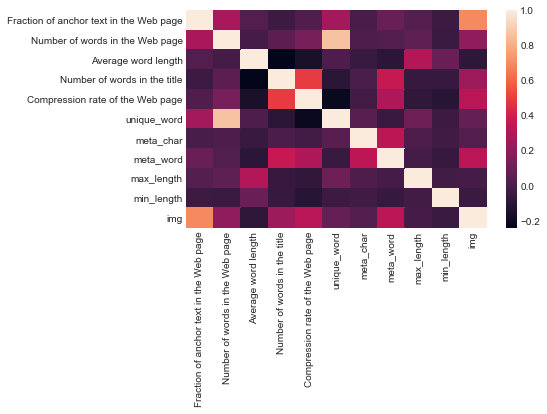

In [677]:
fig, ax = plt.subplots()
sns.heatmap(df.corr(), ax=ax)

In [678]:
df.groupby('class').describe()

Fraction of anchor text in the Web page                               \
                                          count        mean         std  min   
class                                                                          
nonspam                                  5001.0   94.721456  122.370777  0.0   
spam                                     5000.0  110.848600   52.761179  2.0   

                                     Number of words in the Web page  \
           25%    50%    75%     max                           count   
class                                                                  
nonspam   50.0   87.0  126.0  6778.0                          5001.0   
spam     100.0  100.0  138.0  1921.0                          5000.0   

                     ... min_length           img                             \
               mean  ...        75%   max   count       mean        std  min   
class                ...                                                       
nonspam  369.477504  ...        3.0  23.0  5001.0  37.594081  73.187146  0.0   
spam     369.620800  ...        3.0   3.0  5000.0  70.245000  52.711421  0.0   

                                   
          25%   50%   75%     max  
class                              
nonspam   7.0  20.0  44.0  3244.0  
spam     36.0  87.0  87.0  2052.0  

[2 rows x 88 columns]

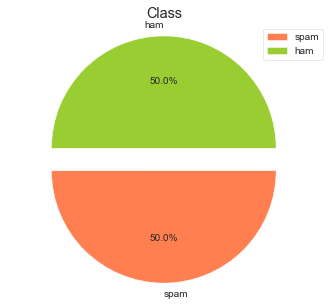

In [679]:
labels = ['spam', 'ham']
x = [5000, 5001] 

fig1, ax1 = plt.subplots(figsize=(5, 5))
ax1.pie(x, labels=labels, explode = (0.3, 0),autopct='%1.1f%%', colors = ['coral','yellowgreen'], 
        radius = 1.5, counterclock = False)
plt.title('Class')
ax1.axis('equal')
ax1.legend(loc='upper left', bbox_to_anchor=(0.8, 1.0))
plt.show()

In [680]:
df['class_num'] = df['class'].map({'nonspam':1, 'spam':0})
df = df.drop(['class'], axis = 1)
df.head()

,Fraction of anchor text in the Web page,Number of words in the Web page,Average word length,Number of words in the title,Compression rate of the Web page,unique_word,meta_char,meta_word,max_length,min_length,img,class_num
0,90,267,6.365385,6,0.805243,52,392,42,20,3,27.0,0
1,90,311,6.480000,15,0.839228,50,538,60,20,3,28.0,0
2,90,295,6.415094,28,0.820339,53,542,60,21,3,28.0,0
3,88,216,6.857143,6,0.773148,49,262,23,27,3,27.0,0
4,90,259,8.000000,6,0.814672,48,242,17,25,3,27.0,0


In [681]:
X = df.drop(['class_num','img', 'unique_word'], axis=1)
y = df['class_num']

In [682]:
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size = 0.3)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7000, 9)
(3001, 9)
(7000,)
(3001,)


In [683]:
r1, r2, tr_tim, pr_tim, run_tim, precis,rec,mean_er, ff = models(clfs, X_train, y_train, X_test, y_test)

MultinomialNB()
Accuracy 0.6384538487170943
ROC AUC 0.7163638899326403
[[1162  336]
 [ 749  754]]
              precision    recall  f1-score   support

           0       0.61      0.78      0.68      1498
           1       0.69      0.50      0.58      1503

    accuracy                           0.64      3001
   macro avg       0.65      0.64      0.63      3001
weighted avg       0.65      0.64      0.63      3001



C:\Users\Admin\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()
Accuracy 0.7874041986004665
ROC AUC 0.8935751105710252
[[1090  408]
 [ 230 1273]]
              precision    recall  f1-score   support

           0       0.83      0.73      0.77      1498
           1       0.76      0.85      0.80      1503

    accuracy                           0.79      3001
   macro avg       0.79      0.79      0.79      3001
weighted avg       0.79      0.79      0.79      3001

SVC(probability=True, random_state=42)
Accuracy 0.8737087637454182
ROC AUC 0.9567089674678236
[[1274  224]
 [ 155 1348]]
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      1498
           1       0.86      0.90      0.88      1503

    accuracy                           0.87      3001
   macro avg       0.87      0.87      0.87      3001
weighted avg       0.87      0.87      0.87      3001

DecisionTreeClassifier(random_state=42)
Accuracy 0.987670776407864
ROC AUC 0.9876735181173034
[[1482   16]
 [  21 1482]]
 

102:	learn: 0.0262213	total: 1.7s	remaining: 14.8s
103:	learn: 0.0259418	total: 1.71s	remaining: 14.8s
104:	learn: 0.0256843	total: 1.73s	remaining: 14.8s
105:	learn: 0.0254775	total: 1.75s	remaining: 14.8s
106:	learn: 0.0249692	total: 1.77s	remaining: 14.8s
107:	learn: 0.0247098	total: 1.78s	remaining: 14.7s
108:	learn: 0.0243719	total: 1.8s	remaining: 14.7s
109:	learn: 0.0239505	total: 1.82s	remaining: 14.7s
110:	learn: 0.0236263	total: 1.83s	remaining: 14.7s
111:	learn: 0.0233521	total: 1.85s	remaining: 14.7s
112:	learn: 0.0231418	total: 1.86s	remaining: 14.6s
113:	learn: 0.0229176	total: 1.88s	remaining: 14.6s
114:	learn: 0.0226605	total: 1.9s	remaining: 14.6s
115:	learn: 0.0223759	total: 1.91s	remaining: 14.6s
116:	learn: 0.0221974	total: 1.93s	remaining: 14.6s
117:	learn: 0.0218979	total: 1.95s	remaining: 14.5s
118:	learn: 0.0218162	total: 1.96s	remaining: 14.5s
119:	learn: 0.0216520	total: 1.97s	remaining: 14.5s
120:	learn: 0.0213257	total: 1.99s	remaining: 14.4s
121:	learn: 0.0

270:	learn: 0.0075315	total: 4.42s	remaining: 11.9s
271:	learn: 0.0074992	total: 4.43s	remaining: 11.9s
272:	learn: 0.0074686	total: 4.46s	remaining: 11.9s
273:	learn: 0.0074572	total: 4.47s	remaining: 11.8s
274:	learn: 0.0074064	total: 4.49s	remaining: 11.8s
275:	learn: 0.0073469	total: 4.5s	remaining: 11.8s
276:	learn: 0.0073349	total: 4.52s	remaining: 11.8s
277:	learn: 0.0073279	total: 4.54s	remaining: 11.8s
278:	learn: 0.0073145	total: 4.55s	remaining: 11.8s
279:	learn: 0.0072541	total: 4.57s	remaining: 11.7s
280:	learn: 0.0072472	total: 4.58s	remaining: 11.7s
281:	learn: 0.0072263	total: 4.6s	remaining: 11.7s
282:	learn: 0.0072062	total: 4.62s	remaining: 11.7s
283:	learn: 0.0071638	total: 4.64s	remaining: 11.7s
284:	learn: 0.0071005	total: 4.65s	remaining: 11.7s
285:	learn: 0.0070551	total: 4.67s	remaining: 11.6s
286:	learn: 0.0070017	total: 4.68s	remaining: 11.6s
287:	learn: 0.0069706	total: 4.7s	remaining: 11.6s
288:	learn: 0.0069555	total: 4.71s	remaining: 11.6s
289:	learn: 0.0

435:	learn: 0.0039281	total: 7.11s	remaining: 9.19s
436:	learn: 0.0039107	total: 7.12s	remaining: 9.18s
437:	learn: 0.0038897	total: 7.14s	remaining: 9.16s
438:	learn: 0.0038764	total: 7.16s	remaining: 9.15s
439:	learn: 0.0038493	total: 7.17s	remaining: 9.13s
440:	learn: 0.0038493	total: 7.19s	remaining: 9.11s
441:	learn: 0.0038493	total: 7.2s	remaining: 9.09s
442:	learn: 0.0038493	total: 7.21s	remaining: 9.06s
443:	learn: 0.0038316	total: 7.22s	remaining: 9.04s
444:	learn: 0.0038162	total: 7.24s	remaining: 9.03s
445:	learn: 0.0038086	total: 7.25s	remaining: 9.01s
446:	learn: 0.0037840	total: 7.26s	remaining: 8.99s
447:	learn: 0.0037839	total: 7.28s	remaining: 8.97s
448:	learn: 0.0037694	total: 7.3s	remaining: 8.95s
449:	learn: 0.0037586	total: 7.31s	remaining: 8.94s
450:	learn: 0.0037485	total: 7.33s	remaining: 8.93s
451:	learn: 0.0037330	total: 7.35s	remaining: 8.91s
452:	learn: 0.0037236	total: 7.37s	remaining: 8.89s
453:	learn: 0.0037236	total: 7.38s	remaining: 8.87s
454:	learn: 0.

601:	learn: 0.0029891	total: 9.45s	remaining: 6.25s
602:	learn: 0.0029789	total: 9.47s	remaining: 6.24s
603:	learn: 0.0029704	total: 9.49s	remaining: 6.22s
604:	learn: 0.0029704	total: 9.51s	remaining: 6.21s
605:	learn: 0.0029701	total: 9.52s	remaining: 6.19s
606:	learn: 0.0029629	total: 9.54s	remaining: 6.17s
607:	learn: 0.0029629	total: 9.55s	remaining: 6.16s
608:	learn: 0.0029629	total: 9.56s	remaining: 6.14s
609:	learn: 0.0029577	total: 9.57s	remaining: 6.12s
610:	learn: 0.0029536	total: 9.59s	remaining: 6.1s
611:	learn: 0.0029536	total: 9.6s	remaining: 6.09s
612:	learn: 0.0029536	total: 9.61s	remaining: 6.07s
613:	learn: 0.0029536	total: 9.63s	remaining: 6.05s
614:	learn: 0.0029379	total: 9.64s	remaining: 6.04s
615:	learn: 0.0029321	total: 9.66s	remaining: 6.02s
616:	learn: 0.0029321	total: 9.67s	remaining: 6s
617:	learn: 0.0029321	total: 9.69s	remaining: 5.99s
618:	learn: 0.0029318	total: 9.7s	remaining: 5.97s
619:	learn: 0.0029178	total: 9.71s	remaining: 5.95s
620:	learn: 0.0029

769:	learn: 0.0027911	total: 11.7s	remaining: 3.5s
770:	learn: 0.0027911	total: 11.7s	remaining: 3.48s
771:	learn: 0.0027910	total: 11.7s	remaining: 3.47s
772:	learn: 0.0027910	total: 11.8s	remaining: 3.45s
773:	learn: 0.0027908	total: 11.8s	remaining: 3.44s
774:	learn: 0.0027908	total: 11.8s	remaining: 3.42s
775:	learn: 0.0027908	total: 11.8s	remaining: 3.4s
776:	learn: 0.0027908	total: 11.8s	remaining: 3.39s
777:	learn: 0.0027906	total: 11.8s	remaining: 3.37s
778:	learn: 0.0027906	total: 11.8s	remaining: 3.36s
779:	learn: 0.0027906	total: 11.8s	remaining: 3.34s
780:	learn: 0.0027904	total: 11.9s	remaining: 3.32s
781:	learn: 0.0027904	total: 11.9s	remaining: 3.31s
782:	learn: 0.0027904	total: 11.9s	remaining: 3.29s
783:	learn: 0.0027904	total: 11.9s	remaining: 3.27s
784:	learn: 0.0027904	total: 11.9s	remaining: 3.26s
785:	learn: 0.0027904	total: 11.9s	remaining: 3.25s
786:	learn: 0.0027833	total: 11.9s	remaining: 3.23s
787:	learn: 0.0027832	total: 11.9s	remaining: 3.21s
788:	learn: 0.

931:	learn: 0.0027633	total: 13.8s	remaining: 1.01s
932:	learn: 0.0027632	total: 13.8s	remaining: 991ms
933:	learn: 0.0027632	total: 13.8s	remaining: 977ms
934:	learn: 0.0027632	total: 13.8s	remaining: 962ms
935:	learn: 0.0027632	total: 13.8s	remaining: 947ms
936:	learn: 0.0027632	total: 13.9s	remaining: 932ms
937:	learn: 0.0027632	total: 13.9s	remaining: 917ms
938:	learn: 0.0027631	total: 13.9s	remaining: 902ms
939:	learn: 0.0027631	total: 13.9s	remaining: 887ms
940:	learn: 0.0027631	total: 13.9s	remaining: 872ms
941:	learn: 0.0027631	total: 13.9s	remaining: 857ms
942:	learn: 0.0027628	total: 13.9s	remaining: 842ms
943:	learn: 0.0027628	total: 13.9s	remaining: 827ms
944:	learn: 0.0027628	total: 13.9s	remaining: 812ms
945:	learn: 0.0027628	total: 14s	remaining: 797ms
946:	learn: 0.0027628	total: 14s	remaining: 782ms
947:	learn: 0.0027625	total: 14s	remaining: 768ms
948:	learn: 0.0027625	total: 14s	remaining: 753ms
949:	learn: 0.0027593	total: 14s	remaining: 738ms
950:	learn: 0.0027593	

In [684]:
res_mod3 = pd.DataFrame(run_tim, index=list(clfs.keys()), columns=['Run time'])
res_mod3['Traing time'] = tr_tim
res_mod3['Test time'] = pr_tim
res_mod3['Accuracy'] = r1
res_mod3['ROC AUC'] = r2
res_mod3['Precision'] = precis
res_mod3['Recall'] = rec
res_mod3['F1'] = ff

In [685]:
mean_er

0.0016661112962345886

In [686]:
res_mod3

,Run time,Traing time,Test time,Accuracy,ROC AUC,Precision,Recall,F1
Naive Bayes,0.018871,0.012913,0.005959,0.638454,0.716364,0.596606,0.638454,0.581566
Logistic regression,0.337729,0.332764,0.004965,0.787404,0.893575,0.718043,0.787404,0.799623
SVM,10.961213,10.633425,0.327789,0.873709,0.956709,0.820724,0.873709,0.876748
Decision tree,0.061619,0.056653,0.004966,0.987671,0.987674,0.982494,0.987671,0.987671
Random forest,1.989689,1.891349,0.098340,0.998001,0.999986,0.996352,0.998001,0.998007
k Nearest Neighbor,0.454457,0.059067,0.395390,0.969344,0.992643,0.956235,0.969344,0.969313
Multilayer Perceptron Classifier,14.574083,14.544286,0.029797,0.968677,0.993180,0.955572,0.968677,0.968625
Gradient boosting,2.646663,2.618906,0.027757,0.997334,0.999905,0.996017,0.997334,0.997339
Ridge Classifier,0.086647,0.082674,0.003973,0.780740,0.780658,0.712718,0.780740,0.791244
CatBoostClassifier,17.072555,17.032165,0.040390,0.998334,0.999992,0.998007,0.998334,0.998335


#  SpamAssassin

In [394]:
import os
os.chdir("D:\ml\\a\\4")

In [395]:
import numpy as np
import pandas as pd
import os
import random
from IPython.display import display, HTML
import email


print(os.listdir("../4"))
spam_path = '../4/spam_2/spam_2/'
easy_ham_path = '../4/easy_ham/easy_ham/'
hard_ham_path = '../4/hard_ham/hard_ham/'
paths = [spam_path, easy_ham_path, hard_ham_path]

email_files = {'spam':     os.listdir(spam_path),
               'easy_ham': os.listdir(easy_ham_path),
               'hard_ham': os.listdir(hard_ham_path)
              }

print('\n spam emails: %d \n \
easy ham emails: %d \n \
hard ham emails: %d \n' %(len(email_files['spam']), len(email_files['easy_ham']), len(email_files['hard_ham']))
     )

['catboost_info', 'easy_ham', 'hard_ham', 'spam_2']

 spam emails: 1397 
 easy ham emails: 2550 
 hard ham emails: 250 



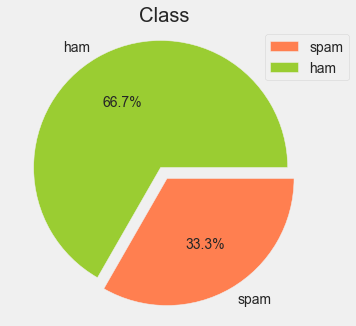

In [480]:
labels = ['spam', 'ham']
x = [1397, 2800] 

fig1, ax1 = plt.subplots(figsize=(5, 5))
ax1.pie(x, labels=labels, explode = (0.15, 0),autopct='%1.1f%%', colors = ['coral','yellowgreen'], 
        radius = 1.5, counterclock = False)
plt.title('Class')
ax1.axis('equal')
ax1.legend(loc='upper left', bbox_to_anchor=(0.8, 1.0))
plt.show()

In [397]:
sum(x)

4197

In [398]:
# path = spam_path
# filename = random.sample(os.listdir(path), 1)[0]

# file = open(path + filename,'r',errors='ignore')

# content = file.read()
# print(content)

In [399]:
# msg = email.message_from_string(content)
# msg
# if msg.is_multipart():
#     bodyy = []
#     print(msg.get_payload())
#     for payload in msg.get_payload():
#         if payload.is_multipart():
#             for payloa in payload.get_payload():
#                 bodyy.append(payloa.get_payload())
#         else:
#             bodyy.append(payload.get_payload())
#     body = '.'.join(bodyy)

# else:
#     body = msg.get_payload()
# print(body)

In [455]:
df = pd.DataFrame(columns=['text','label'])
k=0
body = ' '
for emai in email_files:
    print(emai)
    for i in email_files[emai]:
        if emai == 'spam': path = spam_path
        elif emai == 'easy_ham': path = easy_ham_path
        elif emai == 'hard_ham': path = hard_ham_path
        content = open(path + i,'r',errors='ignore').read()
        msg = email.message_from_string(content)
        #print(i)
        if msg.is_multipart():
            bodyy = []
            #print(msg.get_payload())
            for payload in msg.get_payload():
                if payload.is_multipart():
                    for payloa in payload.get_payload():
                        bodyy.append(payloa.get_payload())
                else:
                    bodyy.append(payload.get_payload())
            body = '.'.join(bodyy)

        else:
            body = msg.get_payload()
    
    
        df.loc[k] = [body,emai]
        k+=1
df

spam
easy_ham
hard_ham


,text,label
0,Greetings!\n\nYou are receiving this letter be...,spam
1,"<html>\n<body>\n<center>\n<h3>\n<font color=""b...",spam
2,"<html>\n<body>\n<center>\n<b>\n<font color=""bl...",spam
3,"<html>\n<body>\n<center>\n<b>\n<font color=""bl...",spam
4,"<html><xbody>\n<hr width = ""100%"">\n<center><h...",spam
...,...,...
4192,Greetings from Geocaching.com -\n\n\nRecent ca...,hard_ham
4193,I am trying to secure three of four virtual ho...,hard_ham
4194,"Filled with useful examples and the depth, cla...",hard_ham
4195,"Linux-Announce Digest #180, Volume #4 ...",hard_ham


In [456]:
df['label_num'] = df.label.map({'hard_ham':1,'easy_ham':1,'spam':0})
df = df.drop(['label'], axis = 1)
df.head()

,text,label_num
0,Greetings!\n\nYou are receiving this letter be...,0
1,"<html>\n<body>\n<center>\n<h3>\n<font color=""b...",0
2,"<html>\n<body>\n<center>\n<b>\n<font color=""bl...",0
3,"<html>\n<body>\n<center>\n<b>\n<font color=""bl...",0
4,"<html><xbody>\n<hr width = ""100%"">\n<center><h...",0


In [457]:
# from nltk.tokenize import sent_tokenize
# from nltk.tokenize import word_tokenize
# from nltk.stem import PorterStemmer, WordNetLemmatizer
# from nltk.corpus import wordnet

# for i in df['text'][:1]:
#     sentences = sent_tokenize(i)
#     for sentence in sentences:
#         words = word_tokenize(sentence)
#         print(words)

In [458]:
import string
from nltk.corpus import stopwords
STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure', 'br','e','v','backffffff','color3d000000']
def text_pre_pro(mess):
    mess = mess.replace('.',' ')
    nopunc = [char for char in mess if char not in string.punctuation]
    
    nopunc = ''.join(nopunc)
    
    return ' '.join([word.lower() for word in nopunc.split() if word.lower() not in STOPWORDS])

In [459]:
df['clean_text'] = df.text.apply(text_pre_pro)
df.head()

,text,label_num,clean_text
0,Greetings!\n\nYou are receiving this letter be...,0,greetings receiving letter expressed interest ...
1,"<html>\n<body>\n<center>\n<h3>\n<font color=""b...",0,html body center h3 font colorblue b need safe...
2,"<html>\n<body>\n<center>\n<b>\n<font color=""bl...",0,html body center b font colorblue bonus fat ab...
3,"<html>\n<body>\n<center>\n<b>\n<font color=""bl...",0,html body center b font colorblue bonus fat ab...
4,"<html><xbody>\n<hr width = ""100%"">\n<center><h...",0,htmlxbody hr width 100 centerh3font color 44c3...


In [460]:
df.clean_text[10]

'yes purchase uncollected judicial judgements st10 company acquaintance uncollected judicial judgement please call us find help receive money court states rightfully due strong interest acquiring uncollected judicial judgements city area j c largest firm world specializing purchase collection judicial judgements currently processing 455 million dollars worth judgements united states alone associate offices virtually every city us foreign countries nothing lose everything gain calling absolutely cost reached toll free 18885575744 us canada call 13108423521 call 24 hours per day thank time ad produced sent add systems ny ny 1 1 r mailing list please email us booginshiphopmaster com r subject 9385'

In [461]:
df['text_len'] = df.clean_text.apply(len)
df.head()

,text,label_num,clean_text,text_len
0,Greetings!\n\nYou are receiving this letter be...,0,greetings receiving letter expressed interest ...,1767
1,"<html>\n<body>\n<center>\n<h3>\n<font color=""b...",0,html body center h3 font colorblue b need safe...,2990
2,"<html>\n<body>\n<center>\n<b>\n<font color=""bl...",0,html body center b font colorblue bonus fat ab...,3650
3,"<html>\n<body>\n<center>\n<b>\n<font color=""bl...",0,html body center b font colorblue bonus fat ab...,3650
4,"<html><xbody>\n<hr width = ""100%"">\n<center><h...",0,htmlxbody hr width 100 centerh3font color 44c3...,1804


In [462]:
df = df.drop(['text'], axis = 1)

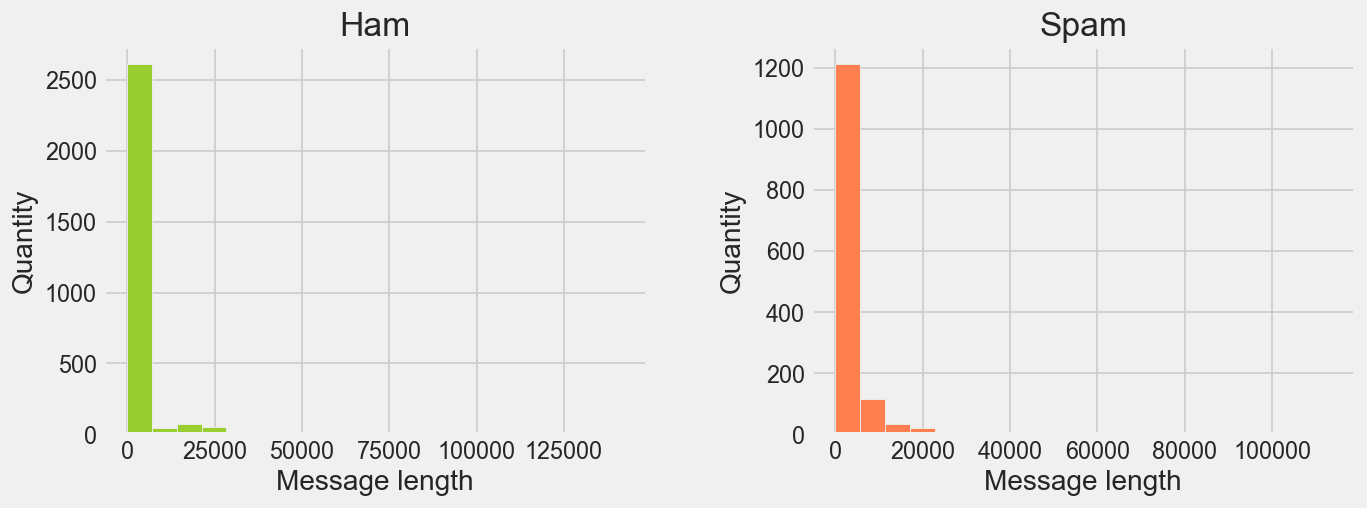

In [483]:
fig,ax = plt.subplots(1,2,figsize=(12,4),dpi = 120)

# df[df['label_num']==2].hist(column='text_len', bins=20,ax=ax[0],color = 'green')
# ax[0].set(xlabel = 'Message length',ylabel = 'Quantity',title = 'Hard Ham')
df[df['label_num']==1].hist(column='text_len', bins=20,ax=ax[0],color = 'yellowgreen')
ax[0].set(xlabel = 'Message length',ylabel = 'Quantity',title = 'Ham')
df[df['label_num']==0].hist(column='text_len', bins=20,ax=ax[1],color = 'coral')
ax[1].set(xlabel = 'Message length',ylabel = 'Quantity',title = 'Spam');

In [464]:
df.head(10)

,label_num,clean_text,text_len
0,0,greetings receiving letter expressed interest ...,1767
1,0,html body center h3 font colorblue b need safe...,2990
2,0,html body center b font colorblue bonus fat ab...,3650
3,0,html body center b font colorblue bonus fat ab...,3650
4,0,htmlxbody hr width 100 centerh3font color 44c3...,1804
5,0,cpurf html head meta httpequiv3dcontenttype co...,12645
6,0,new product announcement outsource eng mfg inc...,1387
7,0,html body bgcolor3dc0c0c0 font face3darial fon...,6527
8,0,dear sir2c urgent confidential3a re3atransfer ...,2396
9,0,doctype html public w3cdtd html 0 transitional...,875


#### Length of HAM

In [465]:
df[df.label_num==1].describe()

,label_num,text_len
count,2800.0,2800.000000
mean,1.0,2171.600000
std,0.0,6186.717334
min,1.0,31.000000
25%,1.0,323.000000
50%,1.0,617.000000
75%,1.0,1163.000000
max,1.0,141804.000000


#### Length of SPAM

In [466]:
df[df.label_num==0].describe()

,label_num,text_len
count,1397.0,1397.000000
mean,0.0,3353.209019
std,0.0,6321.213712
min,0.0,26.000000
25%,0.0,730.000000
50%,0.0,1626.000000
75%,0.0,3735.000000
max,0.0,113399.000000


In [467]:
X = df['clean_text']
y = df['label_num']

In [468]:
X_train1, X_test1, y_train, y_test = train_test_split(X, y,  test_size = 0.3)
print(X_train1.shape)
print(X_test1.shape)
print(y_train.shape)
print(y_test.shape)

(2937,)
(1260,)
(2937,)
(1260,)


In [469]:
y_train

1290    0
1983    1
1888    1
689     0
4108    1
       ..
930     0
1054    0
778     0
410     0
702     0
Name: label_num, Length: 2937, dtype: int64

In [470]:
cv = CountVectorizer()
cv.fit(X_train1)

len(cv.vocabulary_)

100667

In [471]:
X_train = cv.transform(X_train1)
X_train

<2937x100667 sparse matrix of type '<class 'numpy.int64'>'
	with 460426 stored elements in Compressed Sparse Row format>

In [472]:
print(X_train1[X_train1.index[0]])

html head meta httpequivcontenttype contenttexthtml charsetwindows1252 meta namegenerator contentmicrosoft frontpage 0 meta nameprogid contentfrontpage editor document title3title head body stylebackgroundcolor ffff99 div stylewidth 759 height 96 p aligncenterbfont size7nbsp3 5 fixed payment 30 yearsfontbp div font lang0 color008000 familysansserifspan class85107231712042002font color0000ff p aligncenterfont size2 facearialspan class62125431725042002nbspspannbspfont color008000strong lenders makestrongfontfontfontspanfont facearial size2strong wait demand interview intimidate humiliate decide even want tobr business strongfontfontfont lang0 color000000 familysansserifbr fontfont lang0 color000000 size5 familysansserifbfont facearialwe turn tables youre chargefontbfontfont lang0 color000000 familysansserifbr font size2 facearialjust fill simple form compete business fontfontfont lang0 color000000 familysansserif size3 font facearial fonta hrefhttpwww 1strefinance comapply htmbhttpwww 1s

In [473]:
X_train[0].nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([    3,  4158,  5605,  8433,  9725, 12169, 12175, 12194, 13590,
        16851, 18897, 21053, 23350, 23411, 24176, 24177, 24179, 25161,
        25162, 25346, 25379, 25458, 25463, 28003, 28202, 33409, 34005,
        35489, 35640, 35652, 35661, 37882, 37947, 38258, 39563, 39826,
        41170, 42826, 43801, 43910, 43941, 43956, 43993, 44230, 44231,
        44232, 44233, 44234, 44235, 44236, 44237, 44678, 44853, 45057,
        45389, 45392, 45542, 45559, 45888, 46442, 49163, 49309, 50959,
        51933, 52010, 52204, 52205, 52206, 52225, 52250, 53188, 54156,
        54267, 54278, 563

In [474]:
X_test = cv.transform(X_test1)

In [321]:
r1, r2, tr_tim, pr_tim, run_tim, precis, rec, mean_er, ff = models(clfs, X_train, y_train, X_test, y_test)

MultinomialNB()
Accuracy 0.9619047619047619
ROC AUC 0.9799929953594255
[[383  40]
 [  8 829]]
              precision    recall  f1-score   support

           0       0.98      0.91      0.94       423
           1       0.95      0.99      0.97       837

    accuracy                           0.96      1260
   macro avg       0.97      0.95      0.96      1260
weighted avg       0.96      0.96      0.96      1260

LogisticRegression()
Accuracy 0.9738095238095238
ROC AUC 0.9925152026120532
[[399  24]
 [  9 828]]
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       423
           1       0.97      0.99      0.98       837

    accuracy                           0.97      1260
   macro avg       0.97      0.97      0.97      1260
weighted avg       0.97      0.97      0.97      1260

SVC(probability=True, random_state=42)
Accuracy 0.8714285714285714
ROC AUC 0.9815535050035162
[[276 147]
 [ 15 822]]
              precision    recall  f

81:	learn: 0.2821575	total: 1m 34s	remaining: 17m 41s
82:	learn: 0.2804218	total: 1m 35s	remaining: 17m 40s
83:	learn: 0.2790052	total: 1m 37s	remaining: 17m 38s
84:	learn: 0.2774689	total: 1m 38s	remaining: 17m 37s
85:	learn: 0.2763927	total: 1m 39s	remaining: 17m 35s
86:	learn: 0.2746910	total: 1m 40s	remaining: 17m 34s
87:	learn: 0.2724915	total: 1m 41s	remaining: 17m 32s
88:	learn: 0.2711422	total: 1m 42s	remaining: 17m 31s
89:	learn: 0.2697616	total: 1m 43s	remaining: 17m 29s
90:	learn: 0.2683203	total: 1m 45s	remaining: 17m 28s
91:	learn: 0.2667817	total: 1m 46s	remaining: 17m 27s
92:	learn: 0.2653551	total: 1m 47s	remaining: 17m 26s
93:	learn: 0.2639177	total: 1m 48s	remaining: 17m 24s
94:	learn: 0.2627547	total: 1m 49s	remaining: 17m 23s
95:	learn: 0.2609944	total: 1m 50s	remaining: 17m 22s
96:	learn: 0.2592847	total: 1m 51s	remaining: 17m 20s
97:	learn: 0.2581670	total: 1m 52s	remaining: 17m 19s
98:	learn: 0.2570762	total: 1m 54s	remaining: 17m 17s
99:	learn: 0.2559337	total: 

232:	learn: 0.1702429	total: 4m 24s	remaining: 14m 30s
233:	learn: 0.1700258	total: 4m 25s	remaining: 14m 29s
234:	learn: 0.1694752	total: 4m 26s	remaining: 14m 28s
235:	learn: 0.1689416	total: 4m 27s	remaining: 14m 27s
236:	learn: 0.1687096	total: 4m 28s	remaining: 14m 26s
237:	learn: 0.1681760	total: 4m 30s	remaining: 14m 24s
238:	learn: 0.1680551	total: 4m 31s	remaining: 14m 23s
239:	learn: 0.1678387	total: 4m 32s	remaining: 14m 22s
240:	learn: 0.1675293	total: 4m 33s	remaining: 14m 20s
241:	learn: 0.1671911	total: 4m 34s	remaining: 14m 19s
242:	learn: 0.1666396	total: 4m 35s	remaining: 14m 18s
243:	learn: 0.1664206	total: 4m 36s	remaining: 14m 17s
244:	learn: 0.1663196	total: 4m 37s	remaining: 14m 16s
245:	learn: 0.1662620	total: 4m 38s	remaining: 14m 14s
246:	learn: 0.1658794	total: 4m 39s	remaining: 14m 13s
247:	learn: 0.1657582	total: 4m 41s	remaining: 14m 12s
248:	learn: 0.1653356	total: 4m 42s	remaining: 14m 10s
249:	learn: 0.1649923	total: 4m 43s	remaining: 14m 9s
250:	learn:

383:	learn: 0.1354590	total: 7m 9s	remaining: 11m 28s
384:	learn: 0.1350237	total: 7m 10s	remaining: 11m 27s
385:	learn: 0.1348452	total: 7m 11s	remaining: 11m 26s
386:	learn: 0.1344858	total: 7m 12s	remaining: 11m 25s
387:	learn: 0.1344423	total: 7m 13s	remaining: 11m 23s
388:	learn: 0.1344097	total: 7m 14s	remaining: 11m 22s
389:	learn: 0.1341818	total: 7m 15s	remaining: 11m 21s
390:	learn: 0.1339905	total: 7m 16s	remaining: 11m 20s
391:	learn: 0.1339327	total: 7m 18s	remaining: 11m 19s
392:	learn: 0.1336385	total: 7m 19s	remaining: 11m 18s
393:	learn: 0.1336021	total: 7m 20s	remaining: 11m 17s
394:	learn: 0.1335748	total: 7m 21s	remaining: 11m 15s
395:	learn: 0.1333426	total: 7m 22s	remaining: 11m 14s
396:	learn: 0.1332212	total: 7m 23s	remaining: 11m 13s
397:	learn: 0.1329112	total: 7m 24s	remaining: 11m 12s
398:	learn: 0.1328794	total: 7m 25s	remaining: 11m 11s
399:	learn: 0.1328406	total: 7m 26s	remaining: 11m 9s
400:	learn: 0.1326787	total: 7m 27s	remaining: 11m 8s
401:	learn: 0

535:	learn: 0.1142739	total: 10m 5s	remaining: 8m 43s
536:	learn: 0.1142402	total: 10m 6s	remaining: 8m 42s
537:	learn: 0.1141963	total: 10m 7s	remaining: 8m 41s
538:	learn: 0.1141620	total: 10m 8s	remaining: 8m 40s
539:	learn: 0.1141293	total: 10m 9s	remaining: 8m 39s
540:	learn: 0.1138132	total: 10m 11s	remaining: 8m 38s
541:	learn: 0.1137575	total: 10m 12s	remaining: 8m 37s
542:	learn: 0.1136915	total: 10m 13s	remaining: 8m 36s
543:	learn: 0.1136337	total: 10m 14s	remaining: 8m 35s
544:	learn: 0.1133074	total: 10m 15s	remaining: 8m 34s
545:	learn: 0.1128534	total: 10m 16s	remaining: 8m 33s
546:	learn: 0.1125157	total: 10m 18s	remaining: 8m 31s
547:	learn: 0.1124832	total: 10m 19s	remaining: 8m 30s
548:	learn: 0.1124508	total: 10m 20s	remaining: 8m 29s
549:	learn: 0.1124166	total: 10m 21s	remaining: 8m 28s
550:	learn: 0.1123096	total: 10m 22s	remaining: 8m 27s
551:	learn: 0.1122774	total: 10m 23s	remaining: 8m 25s
552:	learn: 0.1119225	total: 10m 24s	remaining: 8m 24s
553:	learn: 0.1

686:	learn: 0.0940521	total: 12m 59s	remaining: 5m 55s
687:	learn: 0.0939575	total: 13m	remaining: 5m 53s
688:	learn: 0.0939115	total: 13m 1s	remaining: 5m 52s
689:	learn: 0.0938849	total: 13m 2s	remaining: 5m 51s
690:	learn: 0.0938588	total: 13m 3s	remaining: 5m 50s
691:	learn: 0.0938135	total: 13m 4s	remaining: 5m 49s
692:	learn: 0.0937877	total: 13m 5s	remaining: 5m 48s
693:	learn: 0.0937618	total: 13m 6s	remaining: 5m 46s
694:	learn: 0.0937217	total: 13m 7s	remaining: 5m 45s
695:	learn: 0.0936961	total: 13m 8s	remaining: 5m 44s
696:	learn: 0.0934144	total: 13m 10s	remaining: 5m 43s
697:	learn: 0.0931659	total: 13m 11s	remaining: 5m 42s
698:	learn: 0.0931403	total: 13m 12s	remaining: 5m 41s
699:	learn: 0.0928670	total: 13m 13s	remaining: 5m 40s
700:	learn: 0.0928411	total: 13m 14s	remaining: 5m 38s
701:	learn: 0.0924865	total: 13m 15s	remaining: 5m 37s
702:	learn: 0.0924611	total: 13m 16s	remaining: 5m 36s
703:	learn: 0.0924355	total: 13m 17s	remaining: 5m 35s
704:	learn: 0.0923910	

837:	learn: 0.0813969	total: 15m 43s	remaining: 3m 2s
838:	learn: 0.0813765	total: 15m 44s	remaining: 3m 1s
839:	learn: 0.0813561	total: 15m 45s	remaining: 3m
840:	learn: 0.0811072	total: 15m 47s	remaining: 2m 59s
841:	learn: 0.0808943	total: 15m 48s	remaining: 2m 57s
842:	learn: 0.0808741	total: 15m 49s	remaining: 2m 56s
843:	learn: 0.0807482	total: 15m 50s	remaining: 2m 55s
844:	learn: 0.0807279	total: 15m 51s	remaining: 2m 54s
845:	learn: 0.0807079	total: 15m 52s	remaining: 2m 53s
846:	learn: 0.0806879	total: 15m 53s	remaining: 2m 52s
847:	learn: 0.0806546	total: 15m 54s	remaining: 2m 51s
848:	learn: 0.0806343	total: 15m 55s	remaining: 2m 49s
849:	learn: 0.0804320	total: 15m 56s	remaining: 2m 48s
850:	learn: 0.0803009	total: 15m 57s	remaining: 2m 47s
851:	learn: 0.0800556	total: 15m 59s	remaining: 2m 46s
852:	learn: 0.0798552	total: 16m	remaining: 2m 45s
853:	learn: 0.0798352	total: 16m 1s	remaining: 2m 44s
854:	learn: 0.0797964	total: 16m 2s	remaining: 2m 43s
855:	learn: 0.0797763	

989:	learn: 0.0718238	total: 18m 28s	remaining: 11.2s
990:	learn: 0.0716503	total: 18m 30s	remaining: 10.1s
991:	learn: 0.0716336	total: 18m 31s	remaining: 8.96s
992:	learn: 0.0716172	total: 18m 32s	remaining: 7.84s
993:	learn: 0.0715893	total: 18m 33s	remaining: 6.72s
994:	learn: 0.0715550	total: 18m 34s	remaining: 5.6s
995:	learn: 0.0714249	total: 18m 35s	remaining: 4.48s
996:	learn: 0.0714084	total: 18m 36s	remaining: 3.36s
997:	learn: 0.0713918	total: 18m 37s	remaining: 2.24s
998:	learn: 0.0711417	total: 18m 38s	remaining: 1.12s
999:	learn: 0.0711253	total: 18m 39s	remaining: 0us
Accuracy 0.9650793650793651
ROC AUC 0.9953636622972397
[[390  33]
 [ 11 826]]
              precision    recall  f1-score   support

           0       0.97      0.92      0.95       423
           1       0.96      0.99      0.97       837

    accuracy                           0.97      1260
   macro avg       0.97      0.95      0.96      1260
weighted avg       0.97      0.97      0.96      1260



In [322]:
res_mod4 = pd.DataFrame(run_tim, index=list(clfs.keys()), columns=['Run time'])
res_mod4['Traing time'] = tr_tim
res_mod4['Test time'] = pr_tim
res_mod4['Accuracy'] = r1
res_mod4['ROC AUC'] = r2
res_mod4['Precision'] = precis
res_mod4['Recall'] = rec
res_mod4['F1'] = ff

In [323]:
res_mod4

,Run time,Traing time,Test time,Accuracy,ROC AUC,Precision,Recall,F1
Naive Bayes,0.256786,0.225495,0.031291,0.961905,0.979993,0.951201,0.961905,0.971864
Logistic regression,6.897615,6.893642,0.003973,0.973810,0.992515,0.968524,0.973810,0.980462
SVM,48.116166,44.416152,3.700014,0.871429,0.981554,0.845000,0.871429,0.910299
Decision tree,3.451048,3.435428,0.015620,0.942857,0.931264,0.938912,0.942857,0.957396
Random forest,9.565796,8.983231,0.582566,0.955556,0.992498,0.948013,0.955556,0.967020
k Nearest Neighbor,1.230982,0.093772,1.137210,0.869841,0.928695,0.856788,0.869841,0.906499
Multilayer Perceptron Classifier,686.038119,685.915481,0.122638,0.969048,0.989910,0.957566,0.969048,0.977153
Gradient boosting,36.452559,36.358892,0.093667,0.950000,0.992217,0.941143,0.950000,0.963006
Ridge Classifier,17.593817,17.593817,0.000000,0.945238,0.931302,0.938085,0.945238,0.959388
CatBoostClassifier,1142.850615,1142.116654,0.733960,0.965079,0.995364,0.957676,0.965079,0.974057


## Results

In [324]:
res_mod1

,Run time,Traing time,Test time,Accuracy,ROC AUC,Precision,Recall,F1
Naive Bayes,0.008977,0.007982,0.000995,0.978469,0.970838,0.981928,0.978469,0.987586
Logistic regression,0.252327,0.251328,0.000998,0.976077,0.981861,0.974717,0.976077,0.986301
SVM,6.171107,5.811869,0.359238,0.976077,0.973960,0.973590,0.976077,0.986320
Decision tree,0.235991,0.234055,0.001936,0.963517,0.892529,0.967137,0.963517,0.979102
Random forest,1.966199,1.825569,0.140630,0.970694,0.979445,0.967158,0.970694,0.983305
k Nearest Neighbor,0.512673,0.000000,0.512673,0.904904,0.798921,0.900749,0.904904,0.947783
Multilayer Perceptron Classifier,133.584896,133.567018,0.017878,0.974880,0.968403,0.973401,0.974880,0.985626
Gradient boosting,2.287212,2.287212,0.000000,0.963517,0.958798,0.961077,0.963517,0.979259
Ridge Classifier,0.113777,0.098153,0.015624,0.969498,0.890483,0.966416,0.969498,0.982624
CatBoostClassifier,86.298293,85.877168,0.421125,0.971890,0.978752,0.968456,0.971890,0.983975


C:\Users\Admin\Anaconda\lib\site-packages\pandas\plotting\_matplotlib\core.py:226: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(
C:\Users\Admin\Anaconda\lib\site-packages\pandas\plotting\_matplotlib\style.py:27: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


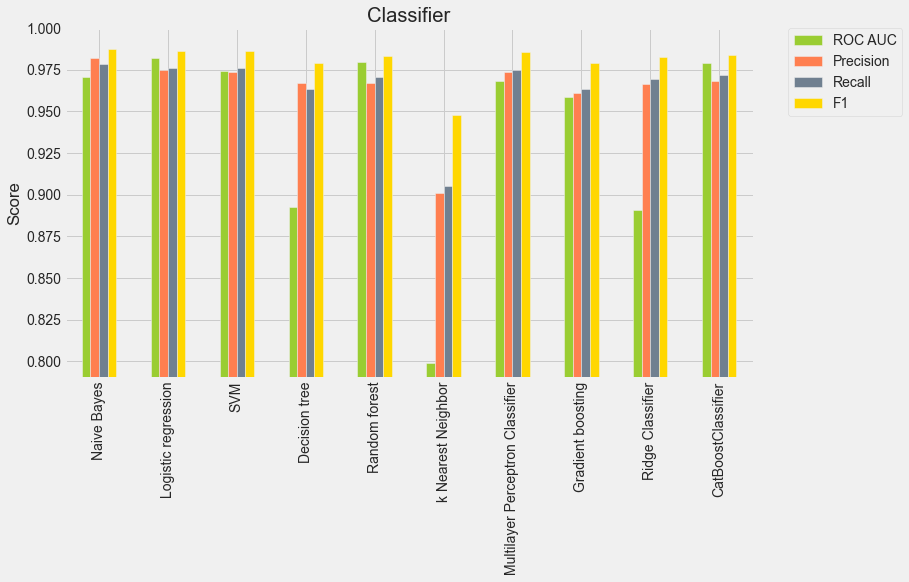

In [486]:
res_mod11 = res_mod1.drop(['Run time'], axis = 1)
res_mod11 = res_mod11.drop(['Traing time'], axis = 1)
res_mod11 = res_mod11.drop(['Test time'], axis = 1)
res_mod11 = res_mod11.drop(['Accuracy'], axis = 1)
res_mod11.plot(kind='bar', ylim=(0.79,1.0), figsize=(11,6), align='center', colormap="Accent",color=['yellowgreen','coral','slategray','gold'])
plt.xticks(np.arange(len(res_mod1)), res_mod1.index)
plt.ylabel('Score')
plt.title('Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [381]:
res_mod4

,Run time,Traing time,Test time,Accuracy,ROC AUC,Precision,Recall,F1
Naive Bayes,0.256786,0.225495,0.031291,0.961905,0.979993,0.951201,0.961905,0.971864
Logistic regression,6.897615,6.893642,0.003973,0.973810,0.992515,0.968524,0.973810,0.980462
SVM,48.116166,44.416152,3.700014,0.871429,0.981554,0.845000,0.871429,0.910299
Decision tree,3.451048,3.435428,0.015620,0.942857,0.931264,0.938912,0.942857,0.957396
Random forest,9.565796,8.983231,0.582566,0.955556,0.992498,0.948013,0.955556,0.967020
k Nearest Neighbor,1.230982,0.093772,1.137210,0.869841,0.928695,0.856788,0.869841,0.906499
Multilayer Perceptron Classifier,686.038119,685.915481,0.122638,0.969048,0.989910,0.957566,0.969048,0.977153
Gradient boosting,36.452559,36.358892,0.093667,0.950000,0.992217,0.941143,0.950000,0.963006
Ridge Classifier,17.593817,17.593817,0.000000,0.945238,0.931302,0.938085,0.945238,0.959388
CatBoostClassifier,1142.850615,1142.116654,0.733960,0.965079,0.995364,0.957676,0.965079,0.974057


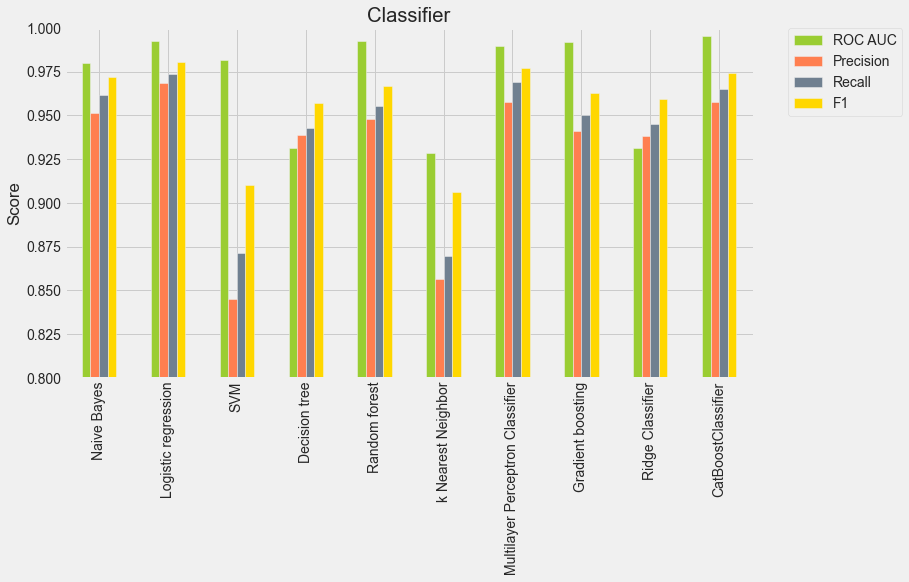

In [487]:
res_mod11 = res_mod4.drop(['Run time'], axis = 1)
res_mod11 = res_mod11.drop(['Traing time'], axis = 1)
res_mod11 = res_mod11.drop(['Test time'], axis = 1)
res_mod11 = res_mod11.drop(['Accuracy'], axis = 1)
res_mod11.plot(kind='bar', ylim=(0.80,1.0), figsize=(11,6), align='center', colormap="Accent",color=['yellowgreen','coral','slategray','gold'])
plt.xticks(np.arange(len(res_mod1)), res_mod1.index)
plt.ylabel('Score')
plt.title('Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [379]:
res_mod3

,Run time,Traing time,Test time,Accuracy,ROC AUC,Precision,Recall,F1
Naive Bayes,0.146022,0.012918,0.133104,0.662446,0.695320,0.620094,0.662446,0.589380
Logistic regression,0.332769,0.326810,0.005959,0.770410,0.884057,0.699886,0.770410,0.782169
SVM,9.586864,9.215358,0.371506,0.863379,0.945370,0.809613,0.863379,0.864776
Decision tree,0.061618,0.056652,0.003973,0.992336,0.992341,0.987712,0.992336,0.992326
Random forest,2.057671,1.931542,0.126129,0.998667,0.999998,0.997333,0.998667,0.998665
k Nearest Neighbor,0.510602,0.060591,0.450011,0.969344,0.992719,0.955660,0.969344,0.969190
Multilayer Perceptron Classifier,17.717072,17.688266,0.028807,0.967011,0.994551,0.951268,0.967011,0.966923
Gradient boosting,2.241251,2.227350,0.013900,0.998334,0.999938,0.996998,0.998334,0.998331
Ridge Classifier,0.018875,0.013919,0.004956,0.754748,0.754870,0.686281,0.754748,0.763800
CatBoostClassifier,15.204471,15.180604,0.023867,0.998001,0.999993,0.996993,0.998001,0.997995


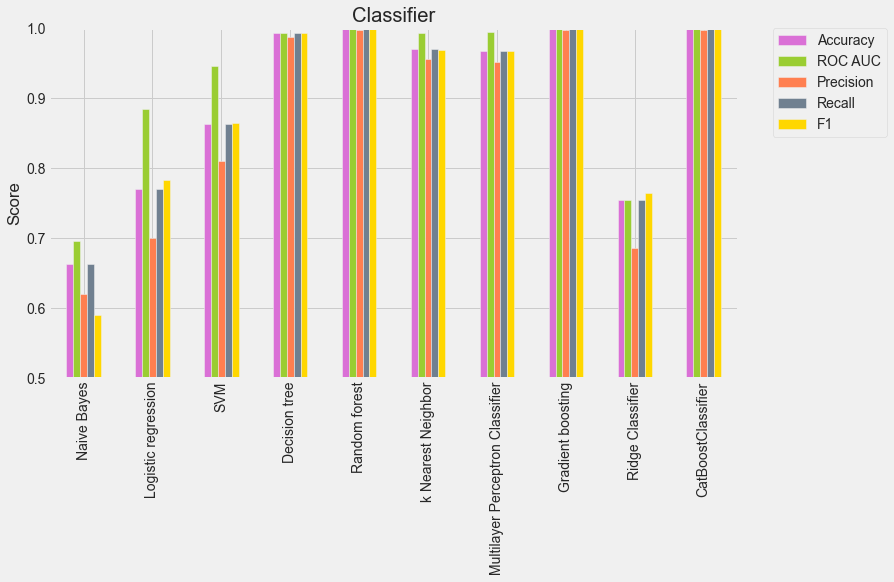

In [499]:
res_mod11 = res_mod3.drop(['Run time'], axis = 1)
res_mod11 = res_mod11.drop(['Traing time'], axis = 1)
res_mod11 = res_mod11.drop(['Test time'], axis = 1)
#res_mod11 = res_mod11.drop(['Accuracy'], axis = 1)
res_mod11.plot(kind='bar', ylim=(0.50,1.0), figsize=(11,6), align='center', colormap="Accent",color=['orchid','yellowgreen','coral','slategray','gold'])
plt.xticks(np.arange(len(res_mod1)), res_mod1.index)
plt.ylabel('Score')
plt.title('Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [668]:
res_mod2

,Run time,Traing time,Test time,Accuracy,ROC AUC,Precision,Recall,F1
Naive Bayes,0.367130,0.335894,0.031236,0.800869,0.849552,0.653970,0.800869,0.739830
Logistic regression,0.605553,0.605553,0.000000,0.930485,0.968409,0.865132,0.930485,0.910448
SVM,10.114698,9.738983,0.375715,0.713975,0.805961,0.533743,0.713975,0.554679
Decision tree,0.156214,0.140594,0.015620,0.912382,0.910075,0.829338,0.912382,0.888889
Random forest,1.509055,1.431025,0.078030,0.954381,0.987597,0.913187,0.954381,0.940622
k Nearest Neighbor,0.596963,0.377874,0.219089,0.800145,0.863415,0.652948,0.800145,0.738636
Multilayer Perceptron Classifier,5.755093,5.739472,0.015621,0.921072,0.973141,0.840075,0.921072,0.902417
Gradient boosting,2.882671,2.851433,0.031238,0.944967,0.985129,0.897386,0.944967,0.927757
Ridge Classifier,0.753982,0.738436,0.015546,0.889935,0.870505,0.807187,0.889935,0.847082
CatBoostClassifier,31.594974,31.438117,0.156857,0.960174,0.988604,0.920568,0.960174,0.948837


C:\Users\Admin\Anaconda\lib\site-packages\pandas\plotting\_matplotlib\core.py:226: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(
C:\Users\Admin\Anaconda\lib\site-packages\pandas\plotting\_matplotlib\style.py:27: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


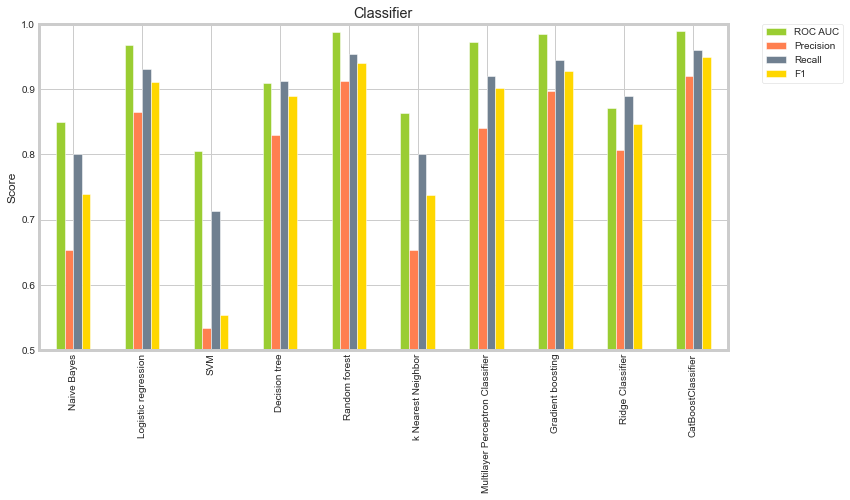

In [669]:
res_mod11 = res_mod2.drop(['Run time'], axis = 1)
res_mod11 = res_mod11.drop(['Traing time'], axis = 1)
res_mod11 = res_mod11.drop(['Test time'], axis = 1)
res_mod11 = res_mod11.drop(['Accuracy'], axis = 1)
res_mod11.plot(kind='bar', ylim=(0.50,1.0), figsize=(11,6), align='center', colormap="Accent",color=['yellowgreen','coral','slategray','gold'])
plt.xticks(np.arange(len(res_mod1)), res_mod1.index)
plt.ylabel('Score')
plt.title('Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [525]:
time_table = res_mod1.drop(['Accuracy','ROC AUC','Precision','Recall','F1','Traing time','Test time'], axis = 1)
time_table.columns = ['Run time on the SMS spam']
time_table['Run time on the Spam Assassin'] = res_mod4['Run time']
time_table['Run time on the Arabic Web Spam'] = res_mod3['Run time']
time_table['Run time on the Email Spam base'] = res_mod2['Run time']

In [526]:
time_table

,Run time on the SMS spam,Run time on the Spam Assassin,Run time on the Arabic Web Spam,Run time on the Email Spam base
Naive Bayes,0.008977,0.256786,0.146022,0.241618
Logistic regression,0.252327,6.897615,0.332769,0.475633
SVM,6.171107,48.116166,9.586864,10.651414
Decision tree,0.235991,3.451048,0.061618,0.157654
Random forest,1.966199,9.565796,2.057671,1.498971
k Nearest Neighbor,0.512673,1.230982,0.510602,0.445772
Multilayer Perceptron Classifier,133.584896,686.038119,17.717072,4.288216
Gradient boosting,2.287212,36.452559,2.241251,2.674614
Ridge Classifier,0.113777,17.593817,0.018875,0.535133
CatBoostClassifier,86.298293,1142.850615,15.204471,31.776744


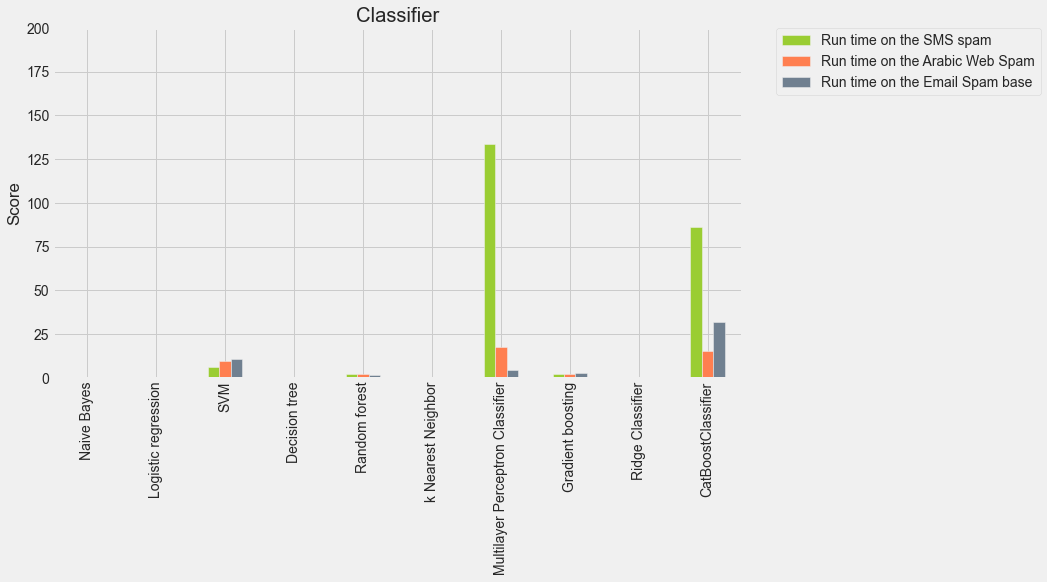

In [523]:
time_table.plot(kind='bar', ylim=(0,200), figsize=(11,6), align='center', colormap="Accent",color=['yellowgreen','coral','slategray','gold'])
plt.xticks(np.arange(len(res_mod1)), res_mod1.index)
plt.ylabel('Score')
plt.title('Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

(11.0, -1.0)

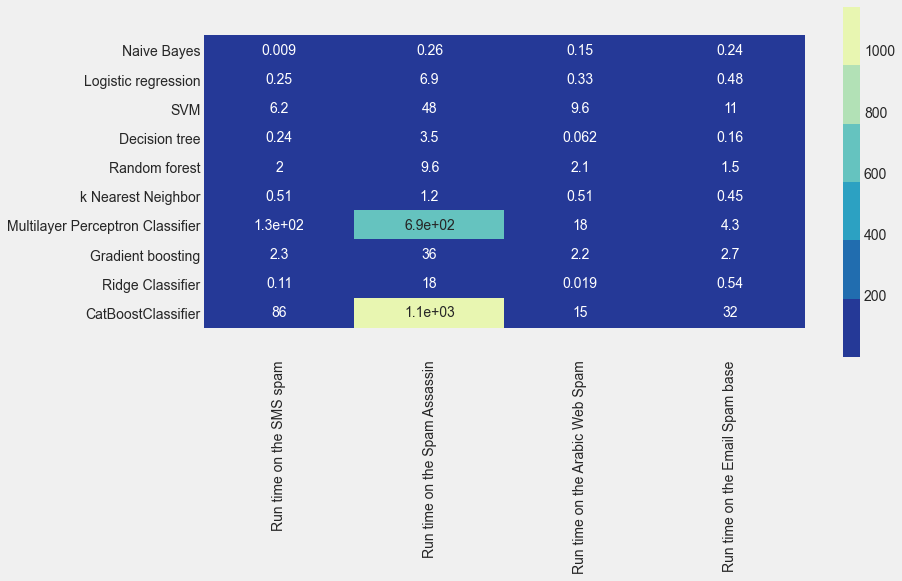

In [530]:
import seaborn as sns
plt.figure(figsize=(12, 6))
ax = sns.heatmap(time_table, annot=True,cmap=sns.color_palette("YlGnBu_r"))
#исправление графического недочета (иначе бы таблица показалась не полностью)
i, k = ax.get_ylim()
ax.set_ylim(i+1, k-1)

In [531]:
time_table.drop(['Multilayer Perceptron Classifier','CatBoostClassifier'], inplace=True)

(9.0, -1.0)

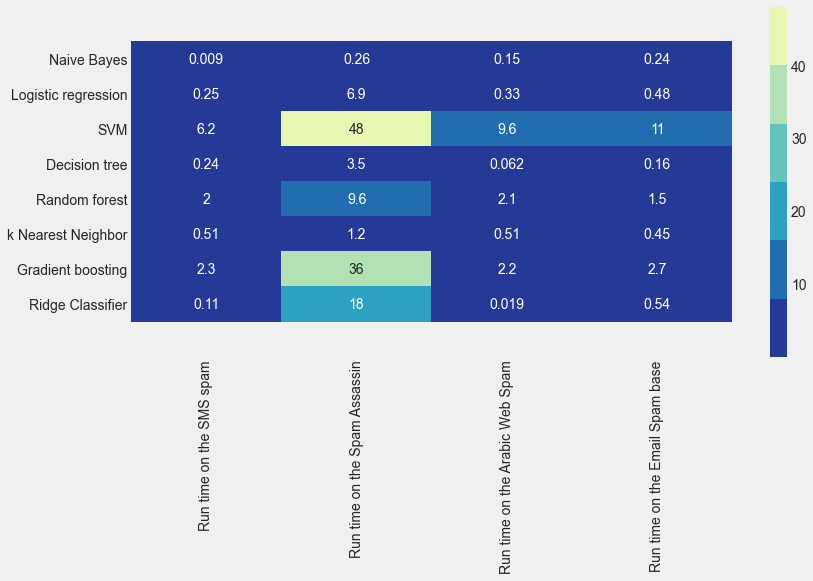

In [532]:
import seaborn as sns
plt.figure(figsize=(12, 6))
ax = sns.heatmap(time_table, annot=True,cmap=sns.color_palette("YlGnBu_r"))
#исправление графического недочета (иначе бы таблица показалась не полностью)
i, k = ax.get_ylim()
ax.set_ylim(i+1, k-1)

http://www2.aueb.gr/users/ion/data/enron-spam/